# 第6章：记忆管理与检索增强

## 6.1 简介：让智能体“记住”和“查找”信息

想象你正在与一个智能体对话，比如问它：“你还记得我昨天说的公司名字吗？” 或者 “我上周上传的那份合同文件，有提到付款日期吗？”——如果智能体总是回答“我不知道”，那它和 ChatGPT 一样只能“短时记忆”，无法成为真正有用的助手。

从这一章开始，我们要教会智能体两项关键能力：
1. **记忆管理**：记住你说过什么；
2. **检索增强**：在知识中查找答案。



### 为什么需要“记忆”与“检索”？

虽然大语言模型（LLMs）本身很强大，但它们有两个天然限制：

1. **没有持久记忆**：用户的对话上下文如果太长，它就会“忘记”前面发生的事情;
2. **知识是静态的**：模型的知识是训练时“死记”的，之后无法自动更新或检索用户提供的新资料。

而我们真正需要的智能体，是能做到以下几点的：

* 能长期记住用户的信息、习惯和偏好（比如用户名、常用术语、任务记录）；
* 能根据用户的提问，在文档或知识库中快速找到相关内容，而不是“胡编”。

这一章就是为了解决这两个问题而设计的。


### “记忆管理”与“检索增强”的区别与联系

| 模块         | 作用              | 类比                   |
| ---------- | --------------- | -------------------- |
| 记忆管理       | 存储并提取用户交互中有用的信息 | 像一个小本子，记下用户说过的重要内容   |
| 检索增强  | 将外部知识加入模型思考过程   | 像在 Google 上查资料后再回答问题 |

在实际应用中，这两者往往是结合使用的。比如构建一个“私人知识助手”时，我们希望它既能记住我们上传过哪些文档，又能在这些文档中查出具体的条款。



### 本章重点内容

* 理解什么是短期记忆（上下文缓存）与长期记忆（持久存储）
* 如何为智能体设计一个“记忆管理器”
* 如何基于文档构建检索增强系统（RAG pipeline）
* 学会使用 `FAISS`等常见向量数据库
* 完成一个支持“记忆+检索”的问答助手



## 6.2 智能体记忆的重要性


### “记忆”的重要性——智能体存在遗忘问题

当我们使用大模型构建智能体时，理想状态是它能**持续理解用户意图、追踪上下文、保持一致性**。但现实往往是这样的：

* 聊了几轮之后，智能体就忘了前面说过什么；
* 用户提到的信息（如名字、任务）没被保留，后续对话无法延续；
* 对话内容稍微长一些，前文就被“截断”了。

这就是智能体面临的遗忘问题，其主要原因是**上下文窗口限制（context window limit）**。

### 上下文窗口限制是什么？
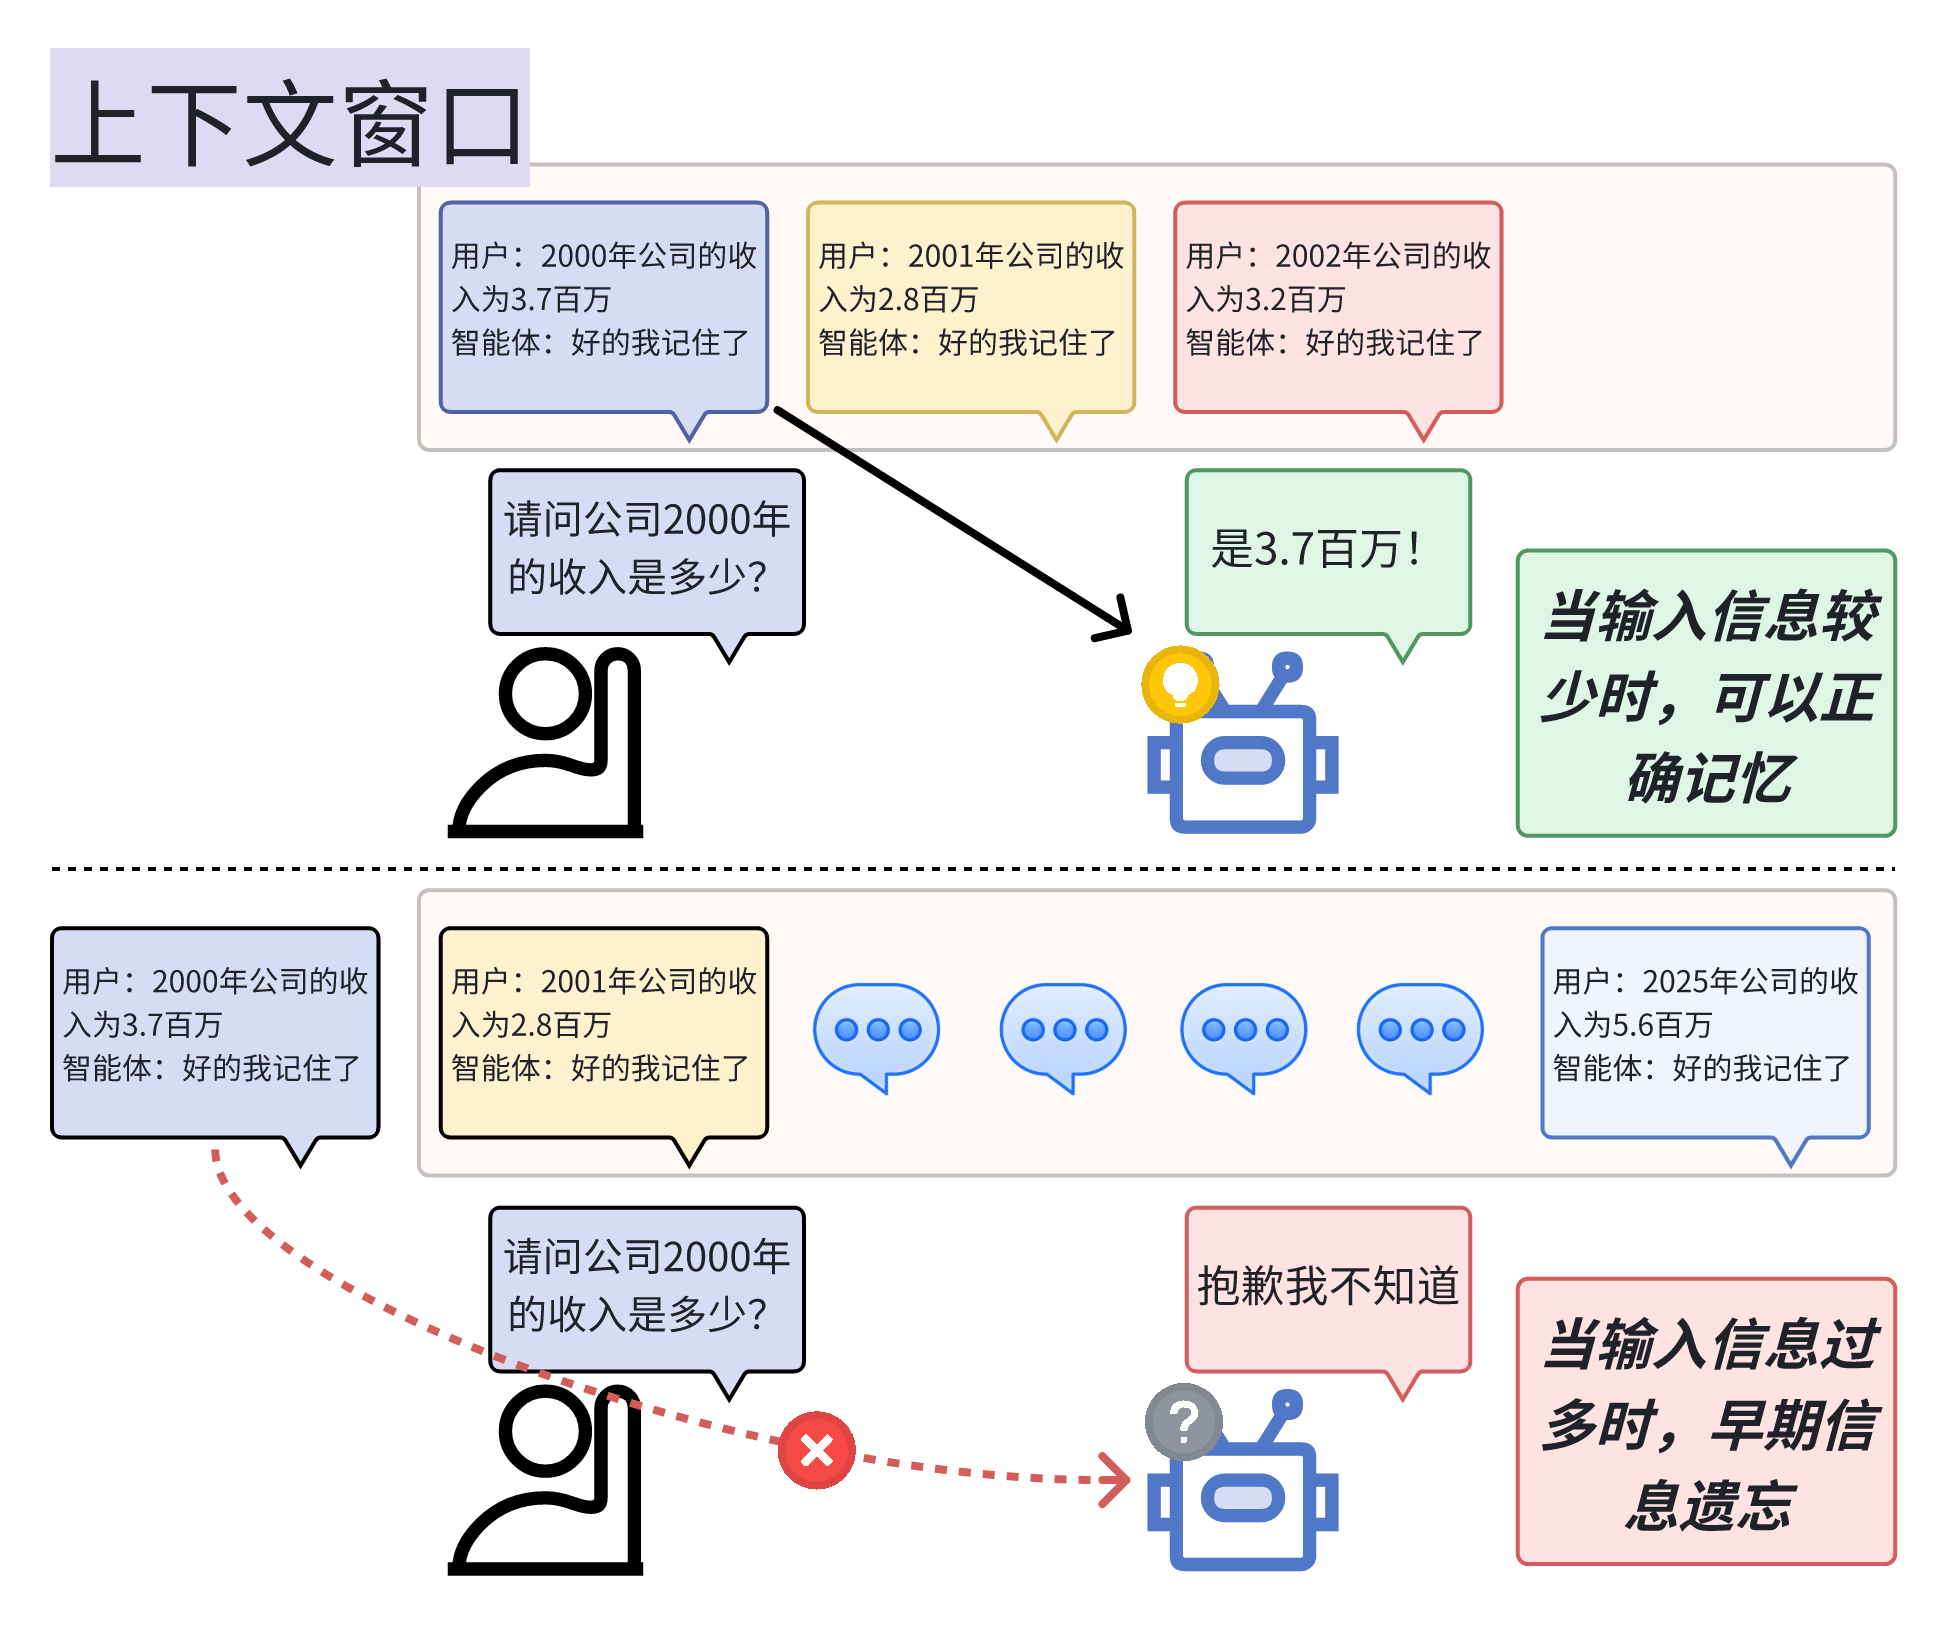

&#x20;*图6.1 大模型都有一个**最大输入长度**的限制，也就是图中的“信息通道”。随着对话轮数的增加，聊天内容会逐渐占据信息通道，直到占满。当达到最大输入长度后，上下文窗口就会向后滑动，导致最初的聊天内容移出窗口，智能体也就不会再看到这部分信息。*

一些常见的模型的上下文窗口大小如下：
* Qwen2.5-7B-Instruct的最大输入长度是131,072 tokens，最大输出长度是8192 tokens（[Qwen2.5-7B-Instruct文档](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct)）；
* DeepSeek-R1的最大上下文长度是128K tokens（[DeepSeek-R1文档](https://huggingface.co/deepseek-ai/DeepSeek-R1)）；

这意味着，一旦上下文内容太长，超出了其窗口限制后，**旧的信息就会被裁剪掉，模型完全“遗忘”它们**。接下来，我们通过一个实验展示智能体可能存在的遗忘现象。




### 实验6-1：没有记忆机制的“遗忘”现象

我们来模拟一下智能体的“遗忘”现象：初始化一个以```Qwen2.5-7B-Instruct```为基座的智能体，告知他多位朋友的生日（这里我们假设有1300个朋友，考察第128个朋友的生日）。在第一组实验中，告知第128个朋友的生日之后立刻询问，智能体可以给出正确回答；但在第二组实验中，告知智能体全部1300个朋友的生日之后再问第128个朋友的生日，由于上下文聊天内容过多，智能体就遗忘了这个朋友的生日。


In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

class QwenAgent:
    def __init__(self, system_prompt="你是一个很聪明的智能体。你会用中文回答用户提出的任何问题。"):
        self.system_prompt = system_prompt
        self.tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")
        self.model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-7B-Instruct", torch_dtype="auto", device_map="auto")
        

    def ask(self, messages):

        text = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)

        generated_ids = self.model.generate(
            **model_inputs,
            max_new_tokens=2048
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return response

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import torch
import random
random.seed(423)
myAgent = QwenAgent()

# 初始上下文：
messages = [
    {"role": "system", "content": myAgent.system_prompt},
]


torch.manual_seed(46)  # 设置种子，确保实验可复现

# 累积对话再询问，产生遗忘现象
for i in range(1300):
    fake_birthday = f"{random.randint(1900, 2025)}年{random.randint(1,12)}月{random.randint(1,28)}日"
    sentence = f"我的第{i+1}个朋友的生日是{fake_birthday}。"
    messages.append({"role": "user", "content": sentence})
    if i == 127:
        print(sentence)
        print("无长对话的回答：")
        messages.append({
            "role": "user",
            "content": "你还记得我第128个朋友的生日吗？"
        })
        print(myAgent.ask(messages))
        messages.pop(-1)
    
messages.append({
        "role": "user",
        "content": "你还记得我第128个朋友的生日吗？"
    })

print("有长对话的回答：")
print(myAgent.ask(messages))

myAgent = None
import gc
gc.collect()  # 清理 Python 的垃圾对象
torch.cuda.empty_cache()  # 释放 PyTorch 缓存显存

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


我的第128个朋友的生日是1919年10月7日。
无长对话的回答：
当然记得，你的第128个朋友的生日是1919年10月7日。如果你有任何关于这些生日的问题或者需要进一步的信息，请告诉我！
有长对话的回答：


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (32768). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


你的第128个朋友的生日是1980年1月19日。


### 实验结果分析：

在刚刚告知智能体第128个朋友的生日后立刻提问，智能体可以回答出正确的生日；但告知了全部朋友的生日之后再提问第128个朋友的生日，智能体就遗忘了该信息，给出了幻觉的回答。这是因为对话轮数过多，智能体会忘记较早的聊天内容。这表明关键的信息（用户身份、任务上下文、偏好设置等）如果**只存在于对话中**，一旦轮次多，就会丢失；对于**长任务流程、多轮协商、长期交互型助手**，如果没有持久记忆，那就不靠谱。因此，我们需要**记忆管理机制**。

### 记忆机制的目标：

| 功能    | 说明                      |
| ----- | ----------------------- |
| 信息提取  | 从上下文中抽取有用信息（如用户姓名、目标任务） |
| 长期存储  | 存入外部存储结构（如数据库、文件、向量库）   |
| 写回注入  | 在需要时重新注入上下文中，避免“遗忘”     |
| 上下文压缩 | 用摘要代替原文，节省token空间       |

通过记忆机制，智能体才能实现**长时对话不中断、任务连续不中断、个性化不中断**。从下一节开始，我们会开始介绍两种记忆——短期、长期记忆。

## 6.3 短期记忆 vs 长期记忆

在智能体系统中，“记忆”通常可以分为**短期记忆**和**长期记忆**。短期记忆指智能体在当前会话中保存和利用最近的交互信息；长期记忆则指智能体跨会话或长时间累计的知识、偏好和历史信息。简而言之，短期记忆关注**眼前**对话的上下文，而长期记忆关注**长远**的知识积累。下面我们分别介绍短期记忆和长期记忆，以及如何在智能体中管理它们。具体学习之前，可以通过如下的示意图直观理解两种记忆的对比与联系。

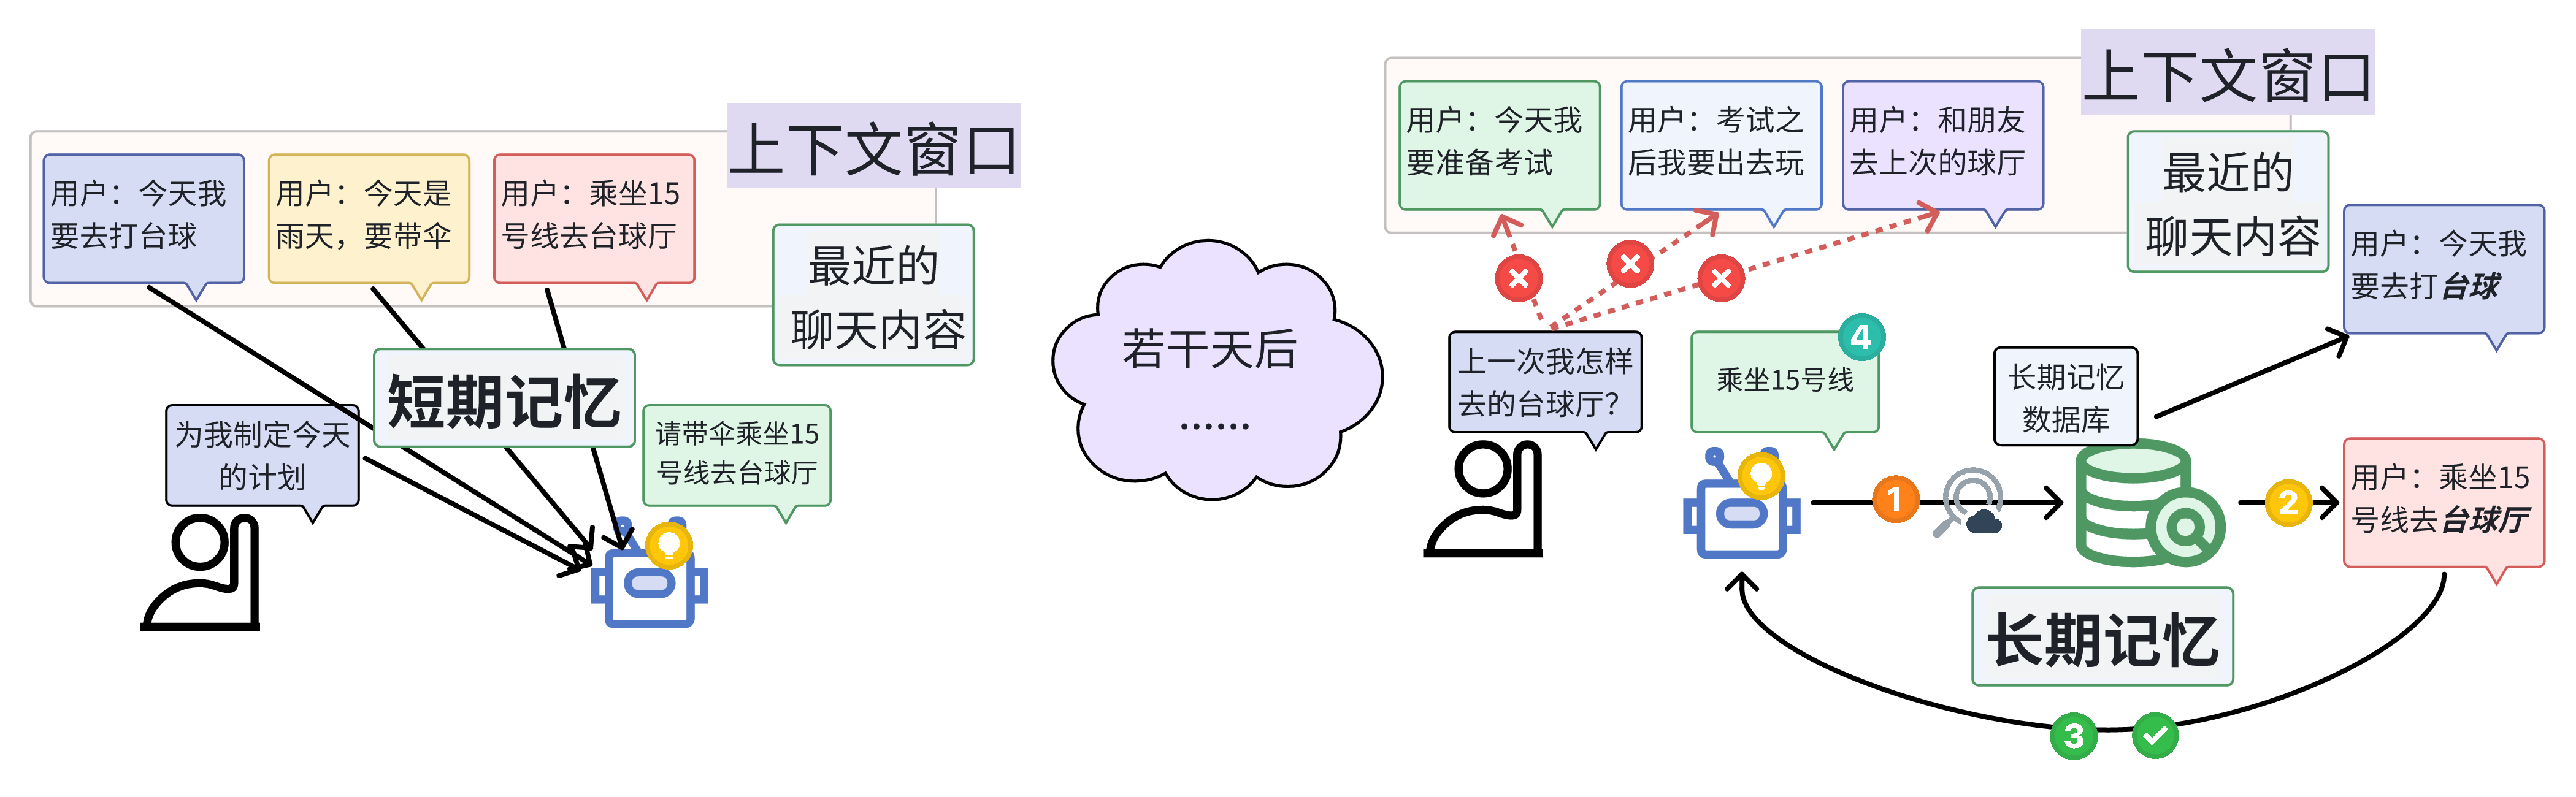

&#x20;*图6.2 短期、长期记忆的示意图。短期记忆把近期的聊天内容放入上下文窗口，智能体可以直接根据内容进行回答；当聊天内容过多时，把旧的信息存储于数据库，当用户询问时到数据库里检索相关的记忆，从而实现长期记忆*


### 6.3.1 短期记忆

我们首先介绍短期记忆的定义，它是指当前对话或最近若干轮交互的内容，这些内容可以直接放入大语言模型（LLM）的上下文中供其参考和生成回答。短期记忆确保智能体能够“记住”对话刚刚发生的内容，从而在连续多轮对话中保持连贯。例如，与客服聊天时，智能体通过短期记忆记住用户刚才提出的问题，以保证下一次回复能够准确针对用户询问。

有句话叫“不用则废”，很多事情如果不加以记录或管理，时间一长我们就会遗忘。大模型智能体也是如此，短期记忆受到LLM上下文窗口长度的限制。每个模型都有固定的最大上下文长度（例如4096或更高的tokens），一旦对话超过这个长度，早期的内容就不得不被**裁剪**或丢弃。这会导致智能体出现“遗忘症”——当对话超过一定长度后，模型可能忘记开头提到的信息，导致回答前后不一致。简单增大模型的上下文窗口并不能根本解决问题，因为无论窗口多大，总会有对话长到超出其限制的一天，而且超长上下文还会带来性能和成本问题。因此，需要有效的短期记忆管理策略。

接下来我们介绍一些常见的短期记忆管理策略，最简单的策略是**滑动窗口**机制，即始终保留最近的K轮对话（K可以根据任务需求设定），将较早的对话内容从上下文中移除。这样可以保证模型上下文不过长，并且模型始终关注最新的交流。然而，单纯按轮数截断有时会丢掉仍然重要的信息。为此，可以结合**摘要**策略：在对话进行过程中，对超出窗口的历史对话生成摘要，将摘要结果保留在上下文中作为压缩的记忆。通过摘要，智能体能够保留更久远的重要信息而不超出上下文长度，例如每当对话超过一定长度，就让模型对早期内容做一个简要概括，并将这个概括留在上下文里，以供后续对话参考。实际应用中，常用的做法是**近期对话 + 历史摘要**：既保留最近若干轮详细对话，又用摘要代表更早的内容，兼顾细节和全局主题。接下来是一个基于滑动窗口机制的短期记忆实现：

### 实验6-2：基于滑动窗口机制的短期记忆实现

In [3]:
import torch
torch.manual_seed(423)  # 设置种子，确保实验可复现

short_memory_agent = QwenAgent()

# 初始化系统信息和对话历史
messages = [
    {"role": "system", "content": short_memory_agent.system_prompt}  # 系统提示（设定智能体的行为或身份）
]
max_rounds = 3  # 最多保留的对话轮数

# 模拟一系列用户提问以构成多轮对话
user_queries = [
    "你好，能跟我聊天吗？", 
    "你叫什么名字？", 
    "我喜欢编程，你呢？", 
    "你还记得我喜欢什么吗？"
]

for idx, query in enumerate(user_queries):
    print(f"-------------------第{idx+1}轮问答开始-------------------")
    # 用户提问加入对话历史
    messages.append({"role": "user", "content": query})
    # 若对话轮数超过限制，则移除最早的一轮对话（用户+助理各一条）
    if len(messages) > 1 + 2 * max_rounds:
        # 除系统消息外，删除最旧的用户和助理消息各一条
        oldest_user_msg = messages.pop(1)  # 删除最旧的用户消息
        oldest_assistant_msg = messages.pop(1)  # 删除最旧的助理回复（删除用户消息后，助理消息变为索引1）
        print("达到短期记忆轮数上限，删除最旧的记忆")
        print(f"删除的用户提问为{oldest_user_msg}")
        print(f"删除的助手回复为{oldest_assistant_msg}")
        
    # 调用模型生成助理回复
    assistant_reply = short_memory_agent.ask(messages)
    # 将助理回复加入对话历史
    messages.append({"role": "assistant", "content": assistant_reply})
    print(f"当前短期记忆为：\n")
    for message in messages[:-2]:
        print(message)
    print(f"当前用户问题：{query}\n")
    print(f"当前问题的回答: {assistant_reply}\n")
    print(f"-------------------第{idx+1}轮问答结束-------------------\n")

short_memory_agent = None
import gc
gc.collect()  # 清理 Python 的垃圾对象
torch.cuda.empty_cache()  # 释放 PyTorch 缓存显存

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


-------------------第1轮问答开始-------------------
当前短期记忆为：

{'role': 'system', 'content': '你是一个很聪明的智能体。你会用中文回答用户提出的任何问题。'}
当前用户问题：你好，能跟我聊天吗？

当前问题的回答: 当然可以！很高兴和您聊天。有什么话题或问题想要讨论吗？我们可以聊聊天气、新闻、电影、书籍，或者分享一些有趣的事情。

-------------------第1轮问答结束-------------------

-------------------第2轮问答开始-------------------
当前短期记忆为：

{'role': 'system', 'content': '你是一个很聪明的智能体。你会用中文回答用户提出的任何问题。'}
{'role': 'user', 'content': '你好，能跟我聊天吗？'}
{'role': 'assistant', 'content': '当然可以！很高兴和您聊天。有什么话题或问题想要讨论吗？我们可以聊聊天气、新闻、电影、书籍，或者分享一些有趣的事情。'}
当前用户问题：你叫什么名字？

当前问题的回答: 我是来自阿里云的大规模语言模型，我叫通义千问。这个名字来源于“通义”和“千问”，寓意着模型具有广泛的知识和能够回答各种问题的能力。您可以叫我千问，有什么问题都可以问我哦！

-------------------第2轮问答结束-------------------

-------------------第3轮问答开始-------------------
当前短期记忆为：

{'role': 'system', 'content': '你是一个很聪明的智能体。你会用中文回答用户提出的任何问题。'}
{'role': 'user', 'content': '你好，能跟我聊天吗？'}
{'role': 'assistant', 'content': '当然可以！很高兴和您聊天。有什么话题或问题想要讨论吗？我们可以聊聊天气、新闻、电影、书籍，或者分享一些有趣的事情。'}
{'role': 'user', 'content': '你叫什么名字？'}
{'role': 'assistant', 'content': '我是来自阿


上述代码维持了一个对话消息列表`messages`，并确保每次生成回复前只保留最近的 `max_rounds` 轮对话记录。在每次用户提问后，我们检查 `messages` 长度，如果超过限制，就用 `pop` 方法移除最早的一对“用户-助理”消息，以腾出空间。这就是**滑动窗口**式的短期记忆管理。实际应用中，我们也可以在移除前对那部分对话进行摘要并将摘要结果保存下来，但在此简化实现中我们直接删除。通过运行该代码，可以看到当对话轮数增加时，智能体的记忆只限于最近的交互内容。例如，如果用户前三次提到自己喜欢编程，那么在第4轮提问“你还记得我喜欢什么吗？”时，若 `max_rounds` 太小导致早期消息被移除，模型可能无法准确回答。这表明短期记忆窗口过小会导致信息丢失；相反，适当增大窗口或引入摘要可以缓解这一问题。

### 6.3.2 长期记忆

与短期记忆相比，长期记忆指智能体在跨会话或长时间跨度上累积的知识和信息。这部分记忆可以包括用户的个人偏好、先前任务的结果、领域知识、甚至是智能体自身“学习”到的新事实等。这些信息不可能每次对话都完整地放入LLM的上下文中，否则既不现实也不高效，因此需要独立的存储和检索机制来管理。长期记忆更类似于一个外部知识库，智能体在需要时检索其中相关内容来辅助当前对话。常见的实现是将长期记忆存储在数据库或文件中，在现代实现中往往使用**向量数据库**存储经过嵌入的记忆表征，并通过语义相似度检索相关条目（本章后续内容会深入讲解这种机制，这里先使用最简单的方法演示）。

长期记忆的内容丰富，可以包含许多类型的信息，主要包括但不限于以下几类：

* **用户偏好和资料：** 例如用户的名称、饮食偏好、兴趣爱好、历史提问记录等。智能体可以利用这些信息提供更加个性化的服务（比如根据用户偏好推荐内容）。
* **历史对话内容摘要：** 跨会话保存的先前重要对话内容或摘要。例如上次会话中用户提出的尚未解决的问题，在下次会话中智能体可以主动提及或跟进。
* **先前任务的结果：** 如果智能体执行过一些任务（如代替用户发送邮件、查询信息等），其结果或经验教训可以保存下来，以便后续遇到类似任务时参考。
* **领域知识：** 智能体在某领域逐步积累的专业知识或事实。例如一个医学问答助手会在长期记忆中保存医学指南、用药常识等供随时检索。

长期记忆的存在使得智能体具有**持续成长**的能力：随着与用户交互的增多，智能体“记住”的东西越来越多，可以逐渐避免重复犯错，减少不一致回答，提高对用户的熟悉程度。例如，一个缺乏长期记忆的智能体就像一条“金鱼”，每次新会话都从零开始，不记得用户上一次提供的信息，这会严重限制用户体验。相反，有了长期记忆，智能体可以像人那样记住过去的重要细节，在不同会话间保持连贯性。例如，如果用户在第一次对话中告诉智能体自己是素食且不吃奶制品，而几天后再次向智能体询问晚餐建议，一个具备长期记忆的智能体会记得用户的饮食偏好并推荐符合要求的菜肴；没有长期记忆的智能体可能会因为忘记这些信息而给出不合适的建议（比如推荐烤肉）。


接下来我们介绍检索机制。由于长期记忆存储在模型上下文之外，智能体需要一种机制在需要时获取其中相关的部分。简单来说，当新的用户请求到来时，智能体可以**根据请求内容从长期记忆中检索**出匹配的信息，将其补充进当前对话上下文，再交由LLM生成答案。检索的方式有简单有复杂：最简单的方式是关键词匹配或规则查找，例如根据用户提问中的关键词在历史记录中搜索；更复杂的方法包括语义搜索（向量检索）、记忆模块调用等（这些高级方法将在后续章节讨论）。关键是在浩瀚的长期记忆中**找出与当前对话最相关**的部分，并提供给模型，从而弥补短期记忆的不足。


### 实验6-3：简易版本的长期记忆实现

为了演示长期记忆的基本机制，我们在上一节短期记忆代码的基础上做扩展。我们将引入一个简单的“长期记忆库”，在对话超过短期记忆窗口时，不再简单地丢弃早期内容，而是将其存入长期记忆。同时，在生成回复前，我们尝试从长期记忆中检索与当前用户问题相关的信息，并将其临时插入对话上下文，从而帮助模型作答。以下是示例代码：


In [4]:
import jieba
import torch
torch.manual_seed(423)  # 设置种子，确保实验可复现

long_memory_agent = QwenAgent()
# 初始化系统信息和对话历史
messages = [
    {"role": "system", "content": long_memory_agent.system_prompt}  # 系统提示（设定智能体的行为或身份）
]

# 长期记忆机制列表
long_term_memory = []  # 用列表保存长期记忆（简单起见，直接存储消息文本）

max_rounds = 3  # 短期记忆窗口为3轮对话

user_queries = [
    "我喜欢编程，你呢？", 
    "请你简要评价一下上海交通大学",
    "给我提供两条学习大模型智能体技术的建议",
    "你还记得我喜欢什么吗？"
]

for idx, query in enumerate(user_queries):
    print(f"-------------------第{idx+1}轮问答开始-------------------")
    messages.append({"role": "user", "content": query})
    print(f"当前用户问题：{query}\n")
    # 如果超过短期记忆窗口，将最早的一轮对话移入长期记忆
    if len(messages) > 1 + 2 * max_rounds:
        # 提取并移除最旧的用户和助理消息
        oldest_user_msg = messages.pop(1)
        oldest_assistant_msg = messages.pop(1)
        # 将其内容存入长期记忆列表（这里直接存文本，可以考虑存摘要）
        long_term_memory.append(oldest_user_msg["content"])
        long_term_memory.append(oldest_assistant_msg["content"])
        print("达到短期记忆轮数上限，删除最旧的记忆，并将其加入长期记忆")
        print(f"添加到长期记忆的用户提问为{oldest_user_msg}")
        print(f"添加到长期记忆的助手回复为{oldest_assistant_msg}")

        ## 这两行用于第四轮问答，测试无长期记忆的效果
        ## 由于窗口上限是3，第一轮对话已经从短期记忆删除，故智能体无法给出回答
        assistant_reply_no_long_memory = long_memory_agent.ask(messages)
        print(f"当前问题的回答（无长期记忆）: {assistant_reply_no_long_memory}\n")
    
    # 检索长期记忆：简单关键词匹配当前用户问题
    retrieved_info = None
    for mem in long_term_memory:
        if any(word in mem for word in jieba.lcut(query)):  # 若记忆中有当前提问相关的词
            retrieved_info = mem
            break
    # 如果找到相关记忆，将其作为系统消息插入，提示模型
    if retrieved_info:
        print(f"根据当前用户问题，在长期记忆中检索到如下相关内容：\n {retrieved_info}")
        messages.insert(1, {"role": "system", "content": f"(记忆检索提示: {retrieved_info})"})
    # 生成助理回复
    assistant_reply = long_memory_agent.ask(messages)
    print(f"当前问题的回答（使用长期记忆）: {assistant_reply}\n")
    # 加入对话历史
    messages.append({"role": "assistant", "content": assistant_reply})
    # 若刚才插入了记忆提示，为避免干扰后续轮次，将其移除
    if retrieved_info:
        messages.pop(1)
        
    
    print(f"-------------------第{idx+1}轮问答结束-------------------")

long_memory_agent = None
import gc
gc.collect()  # 清理 Python 的垃圾对象
torch.cuda.empty_cache()  # 释放 PyTorch 缓存显存

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


-------------------第1轮问答开始-------------------
当前用户问题：我喜欢编程，你呢？

当前问题的回答（使用长期记忆）: 作为一个智能体，我没有个人喜好或情感，但我非常乐意与你讨论编程相关的话题！你对编程有什么特别的兴趣或者遇到什么难题需要帮助吗？

-------------------第1轮问答结束-------------------
-------------------第2轮问答开始-------------------
当前用户问题：请你简要评价一下上海交通大学

当前问题的回答（使用长期记忆）: 上海交通大学是一所历史悠久、声誉卓著的高等学府，是中国顶尖的综合性大学之一。学校位于中国上海市，拥有悠久的历史和丰富的文化底蕴。上海交通大学在多个学科领域具有很高的学术水平和研究实力，特别是在工程、医学、管理、人文科学等领域有着显著的优势。

学校拥有一流的教学设施和科研平台，吸引了众多国内外知名学者任教。此外，上海交通大学还与众多企业和机构保持着紧密的合作关系，为学生提供了丰富的实践机会和就业资源。

总的来说，上海交通大学是一所综合实力强大的高校，对于有志于深造和发展的学生来说是一个很好的选择。如果你有更具体的问题或需要进一步的信息，请告诉我！

-------------------第2轮问答结束-------------------
-------------------第3轮问答开始-------------------
当前用户问题：给我提供两条学习大模型智能体技术的建议

当前问题的回答（使用长期记忆）: 当然可以！以下是两条关于学习大模型智能体技术的建议：

1. **深入理解基础理论**：
   - **数学基础**：大模型智能体通常基于深度学习技术，因此扎实的数学基础（如线性代数、概率论、微积分）非常重要。
   - **机器学习和深度学习**：学习并掌握机器学习的基本概念和深度学习的关键算法（如卷积神经网络、循环神经网络、Transformer等）。
   - **自然语言处理（NLP）**：了解自然语言处理的基础知识，特别是如何处理文本数据，这对于学习大模型智能体尤为重要。

2. **实践项目和开源库**：
   - **参与实践项目**：通过实际项目来应用你学到的知识。可以从简单的任务开始，比

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


当前问题的回答（无长期记忆）: 根据我们之前的对话记录，我没有特定的信息表明你喜欢什么。如果你之前提到过自己的兴趣爱好或者偏好，可以告诉我具体的细节，我会尽力帮助你回忆起来。如果你有任何特别的话题或者领域想要讨论，也可以直接告诉我，我们一起探讨一下！



Loading model cost 0.513 seconds.
Prefix dict has been built successfully.


根据当前用户问题，在长期记忆中检索到如下相关内容：
 我喜欢编程，你呢？
当前问题的回答（使用长期记忆）: 根据之前的对话，我记得你喜欢编程。如果你有任何关于编程或其他方面的问题，欢迎随时提问！我可以帮助你解答或提供更多相关的信息。

-------------------第4轮问答结束-------------------


上述代码实现了一个朴素的长期记忆存取过程：

* **存储：** 当对话长度超过短期窗口限制时，我们将最早的一对“用户提问和助理回答”移出`messages`，并将它们的文本内容追加到`long_term_memory`列表中，从而保存到长期记忆。现实中可以选择有价值的信息存储，比如只存用户提供的关键信息或对话摘要；这里为了简单，我们直接存储了整条消息内容。
* **检索：** 在每次生成回复之前，我们根据当前用户提问在长期记忆列表中进行一次遍历查找。如果发现某条记忆内容包含当前提问中的关键词，就认为这条记忆可能有关联。我们将找到的相关记忆作为一个特殊的系统消息插入到当前对话的开头（紧随原始系统提示之后），用括号注明这是检索到的记忆提示。这样做是为了显式将过去的相关信息提供给模型。在生成回复后，我们再将这个临时插入的记忆提示移除，避免影响后续步骤。

通过这种简单机制，我们实现了一个**基于关键词的记忆检索**。例如，如果早先的对话中用户提到“我最喜欢的颜色是蓝色”并已被移入长期记忆，那么当用户稍后再次问“我最喜欢的颜色是什么？”时，代码会在长期记忆中找到包含“颜色”或“蓝色”的那条记录，并将其提示给模型。模型因此能够根据提示回答出用户最喜欢的颜色是蓝色。而如果没有这一步骤，模型很可能因短期记忆中已无相关信息而无法作答或给出错误答案。

需要注意，这里的检索算法非常简陋，实际效果取决于关键词匹配的巧合程度。在真实应用中，我们会用更加智能的检索技术（如向量语义搜索）来寻找长期记忆中和用户查询语义相关的内容，并可能使用更复杂的策略决定插入多少条记忆、如何插入等。本节旨在展示长期记忆管理的核心思想：**将超出短期上下文的历史信息保存起来，并在需要时取出提供给模型**。有了长期记忆机制，智能体就能在多个会话间保持上下文连贯，不断累积知识，提高交互表现，实现更**拟人化**和**持续化**的对话体验，这些内容将在6.5节进行更加细致地讲解。


## 6.4 内存管理策略

在长对话中，LLM只能“记住”其**上下文窗口**内的内容。当对话超过这个长度时，超出窗口的旧内容就会被遗忘。尽管最新的Qwen2.5-7B等模型将上下文长度提升到上万甚至十万级，但总体来说**上下文窗口是有限的**。因此，对于持续的多轮对话，必须设计策略来管理有限的上下文，实现“短期记忆”与“长期记忆”的平衡。接下来，本节将对6.3节中短期记忆的管理策略进行更加详细地讲解。

### 6.4.1 上下文窗口管理

如前文所说，随着对话轮次增多，聊天记录累积，占用的token接近模型上下文窗口上限时，模型将无法接受新的输入。为避免超出长度，我们需要在保持对话连贯性的同时，对历史记录进行取舍。如下是两种常见的策略：

* **滑动窗口保留近期对话**：该策略已经在6.3节中进行了简要的介绍，我们始终仅保留最近若干轮对话在prompt中，移除最早的对话内容。这种方法简单直接，可确保模型**始终关注最新话题**，不会因为旧信息过多而超长。短期记忆的管理通过限制保存的最近对话轮数来实现。当对话轮数超过设定值时，移除最早的对话记录（或在实际应用中可以替换为将其摘要后再保存）。

* **基于重要性的记忆选择**：其核心思想是通过评分机制（如 TF-IDF、注意力权重、打分模型）判断历史信息的重要程度，仅保留最关键的内容。相比于滑动窗口，该策略能保留更有价值的历史信息，适合需要跨较长时间提取关键信息的任务。在实现上，我们可以维护一个动态变化的堆，每增加一条对话，就先对其打分，根据分数的高低加入到堆里；在下一次问答前，取分数最高的几条记忆作为短期记忆。如下用一个简单的demo展示如何实现这样的记忆选择，这里仅仅是最基本的示例。

### 实验6-4 基于重要性的记忆选择


In [5]:
import heapq
# 参数
max_memory_items = 2  # 最多保留2条非系统消息

# 用户模拟输入，这里作为示例直接给出评分
user_queries_with_scroes = {
    "你好，能跟我聊天吗？": 1,    ## 普通问候，重要性较低
    "你叫什么名字？" : 2,        ## 问句，轻度重要
    "我喜欢编程，你呢？" : 5,     ## 包含“喜欢”“编程”，高重要性
    "你还记得我喜欢什么吗？": 1   ## 对之前对话的重复，不重要
}

# 系统提示 + 初始化记忆池（仅保留用户消息）
system_prompt = {"role": "system", "content": "你是一个善于对话的AI助手。"}
memory_heap = []  # 小根堆 (score, index, message)

# 模拟对话过程（依次处理每条输入）
for idx, (query, score) in enumerate(user_queries_with_scroes.items()):
    message = {"role": "user", "content": query}

    # 将当前消息插入堆
    heapq.heappush(memory_heap, (score, idx, message))

    # 超出容量时弹出最不重要的
    if len(memory_heap) > max_memory_items:
        removed = heapq.heappop(memory_heap)
        print(f"删除记忆：{removed[2]['content']}（分数 {removed[0]}）")

    # 展示当前记忆
    print(f"\n当前记忆内容（保留重要性前{max_memory_items}条）：")
    for s, i, m in sorted(memory_heap, reverse=True):
        print(f"- {m['content']}（分数 {s}）")

    print("-" * 40)



当前记忆内容（保留重要性前2条）：
- 你好，能跟我聊天吗？（分数 1）
----------------------------------------

当前记忆内容（保留重要性前2条）：
- 你叫什么名字？（分数 2）
- 你好，能跟我聊天吗？（分数 1）
----------------------------------------
删除记忆：你好，能跟我聊天吗？（分数 1）

当前记忆内容（保留重要性前2条）：
- 我喜欢编程，你呢？（分数 5）
- 你叫什么名字？（分数 2）
----------------------------------------
删除记忆：你还记得我喜欢什么吗？（分数 1）

当前记忆内容（保留重要性前2条）：
- 我喜欢编程，你呢？（分数 5）
- 你叫什么名字？（分数 2）
----------------------------------------


### 6.4.2 内容摘要与提取

针对重要但较早的内容，另外一种策略是不直接删除，而是**压缩其要点**，以紧凑形式保留在prompt中。具体做法是利用模型或算法将长对话历史摘要为简短的几句话或要点列表，只保留关键信息，从而大幅减少tokens占用。例如，当对话长度接近窗口上限时，可以触发一个摘要操作，生成当前会话的简要概述，然后将详细的历史对话替换为这份概述插入到prompt开头。这样模型在新一轮仍能“记住”之前讨论过的主题和要点，但所占用的tokens大大减少。摘要策略常结合滑动窗口一起使用：即**新对话保留详细内容，较早对话用摘要代表，形成结合短期详细记忆和长期压缩记忆的提示**。

大型语言模型本身擅长语言概括和重述，我们可以直接利用它来压缩对话内容。给模型适当的提示，它能将一段长对话概括为简短摘要、要点列表，或提取其中所需的信息。这种**让模型当自己的"记忆提炼器"**的方法非常实用，可以极大节省上下文空间，用少量tokens保留了对话的关键信息，腾出宝贵的窗口空间用于新对话内容。摘要应尽量**覆盖主要语义**，例如对话的主题、用户的目标和偏好、已完成的任务等，以便模型后续轮次不忘“大局”。实践表明，在提示中加入之前对话的摘要，有助于模型在长对话中保持上下文一致性和语义连贯。

**摘要类型**：根据应用需求，摘要的侧重点可以不同，主要分为两类：

* **任务进展类摘要**：侧重于总结对话中**行动事项和进度**的要点。例如在一个助理帮用户完成任务的多轮对话中，助手可以每隔几轮将已执行的步骤、得到的结论以及后续待办事项列出来。这类似于生成对话的“行动日志”或“会议纪要”。这样即使详细过程被省略，模型也能依据摘要了解目前任务到了哪一步。

* **人物信息提取类摘要**：侧重提取对话中透露的**用户偏好、习惯、约束**等关键信息。比如用户在多轮交谈中提到了自己的兴趣爱好、背景故事，那么通过总结，这些人物属性可以被提炼出来，供后续对话个性化使用。相当于建立一份“用户档案”记忆，让助手在长对话中保持对用户情况的了解。

下面通过代码演示如何利用Qwen模型对一段多轮对话生成不同类型的摘要：

### 实验6-5 利用大模型智能体分别对任务进展与任务信息进行摘要

In [6]:
import torch
torch.manual_seed(423)  # 设置种子，确保实验可复现

summary_agent = QwenAgent()

# 假设有一段多轮对话文本（中文），模拟用户和助手的互动
dialogue_text = """用户: 我计划下个月去旅游，现在在做攻略。
助手: 好的，请问你有心仪的目的地吗？
用户: 我喜欢海滩和美食，预算不高，最好别太热门的地方。
助手: 明白了。我建议你考虑东南亚的海岛，例如泰国的甲米，那里的海滩很美... (此处省略若干对话) ...
用户: 好的，那需要提前准备什么吗？
助手: 你可以先办理签证，预订机票和酒店...接下来我们可以列一个任务清单来跟进。
用户: 太好了，我们开始吧！"""
 
# 1. 生成任务进展类摘要：总结对话中的主要任务和进度
prompt1 = f"阅读以下对话，为其中提到的旅游计划生成一个任务清单，包含目前完成的事项和待办事项：\n{dialogue_text}"
messages = [
    {"role": "system", "content": "你是一个善于整理任务的助手。"},
    {"role": "user", "content": prompt1}
]
summary_tasks = summary_agent.ask(messages)
print("-------------------任务清单摘要:-------------------\n", summary_tasks)

# 2. 生成人物信息提取类摘要：提取用户的兴趣、偏好等信息
prompt2 = f"请从上述对话中提取用户的个人偏好和习惯，并用几句话总结：\n{dialogue_text}"
messages[1]["content"] = prompt2  # 替换为新的用户请求
summary_profile = summary_agent.ask(messages)
print("-------------------用户偏好摘要:-------------------\n", summary_profile)

summary_agent = None
import gc
gc.collect()  # 清理 Python 的垃圾对象
torch.cuda.empty_cache()  # 释放 PyTorch 缓存显存

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


-------------------任务清单摘要:-------------------
 好的，根据您的描述，已经确定了一个目的地并且对旅行做了初步规划，下面将为您整理一份详细的旅游计划任务清单：

### 完成事项
- [X] 确定旅游目的地：泰国甲米
- [X] 初步了解当地文化、气候、景点等信息

### 待办事项
1. **签证**
   - [ ] 核实所需签证类型及申请流程
   - [ ] 收集并提交必要的申请材料
   - [ ] 预约签证办理时间并支付相关费用
2. **交通**
   - [ ] 比较不同航空公司的价格与航班时间
   - [ ] 预订往返机票
3. **住宿**
   - [ ] 浏览酒店网站或旅游平台，比较不同酒店的价格与评价
   - [ ] 预订酒店房间
4. **餐饮**
   - [ ] 了解当地的特色美食及推荐餐厅
5. **行程规划**
   - [ ] 研究当地景点，制定初步行程安排
6. **打包行李**
   - [ ] 根据天气预报和活动计划准备衣物和其他必需品
7. **保险**
   - [ ] 考虑购买旅行保险以应对可能发生的意外情况
8. **其他**
   - [ ] 准备一些常用药物和个人用品
   - [ ] 检查护照有效期并办理续签（如需）
   - [ ] 了解当地的安全提示和紧急联系方式

请按照这个清单逐步推进您的旅行准备工作。希望您能有一个愉快的旅程！
-------------------用户偏好摘要:-------------------
 用户偏好和习惯总结：用户计划下个月进行一次非热门的、以海滩和美食为主的低成本旅行。用户对目的地的要求是环境优美且不太拥挤，同时预算有限。在准备过程中，用户愿意遵循建议并积极跟进行程安排。


在上面的代码中，我们首先构造了一段关于旅游计划的对话样本，其中涉及了用户喜欢什么、预算限制，以及助手指导下的任务步骤。然后：

* 我们让模型生成“任务清单摘要”，期待输出一个列举对话中**已经完成**和**待完成**事项的列表。例如模型可能输出：已确定偏好地点（海滩、美食、不热门）、待选择具体目的地、待办理签证、待预订机票酒店… 等等。这对应对话的任务进展概要。

* 接着我们让模型提取“用户偏好摘要”，模型可能会输出几句话总结用户喜欢海滩、美食、预算有限、不喜欢人多等偏好要点，形成用户画像。

**注意**：实际运行时，模型生成的摘要质量取决于指令设计和模型能力。为了提高准确性，可以在提示中明确要求例如“只使用对话提供的信息，不要添加编造成分”等。另外，如果摘要结果有误差，可能需要在后续对话中由助手向用户确认关键细节，以免“记忆”偏差。

通过**对话前摘要 + 当前对话 + 后续补充**的流程（如下图所示），我们能够在每次与LLM交互时，将必要的历史信息（经过筛选或概括）提供给模型，同时不断更新“内存”。这样既控制了提示长度不上溢，又让模型在长对话中保持对过去重要内容的掌握，从而实现更智能的**记忆增强**对话代理。

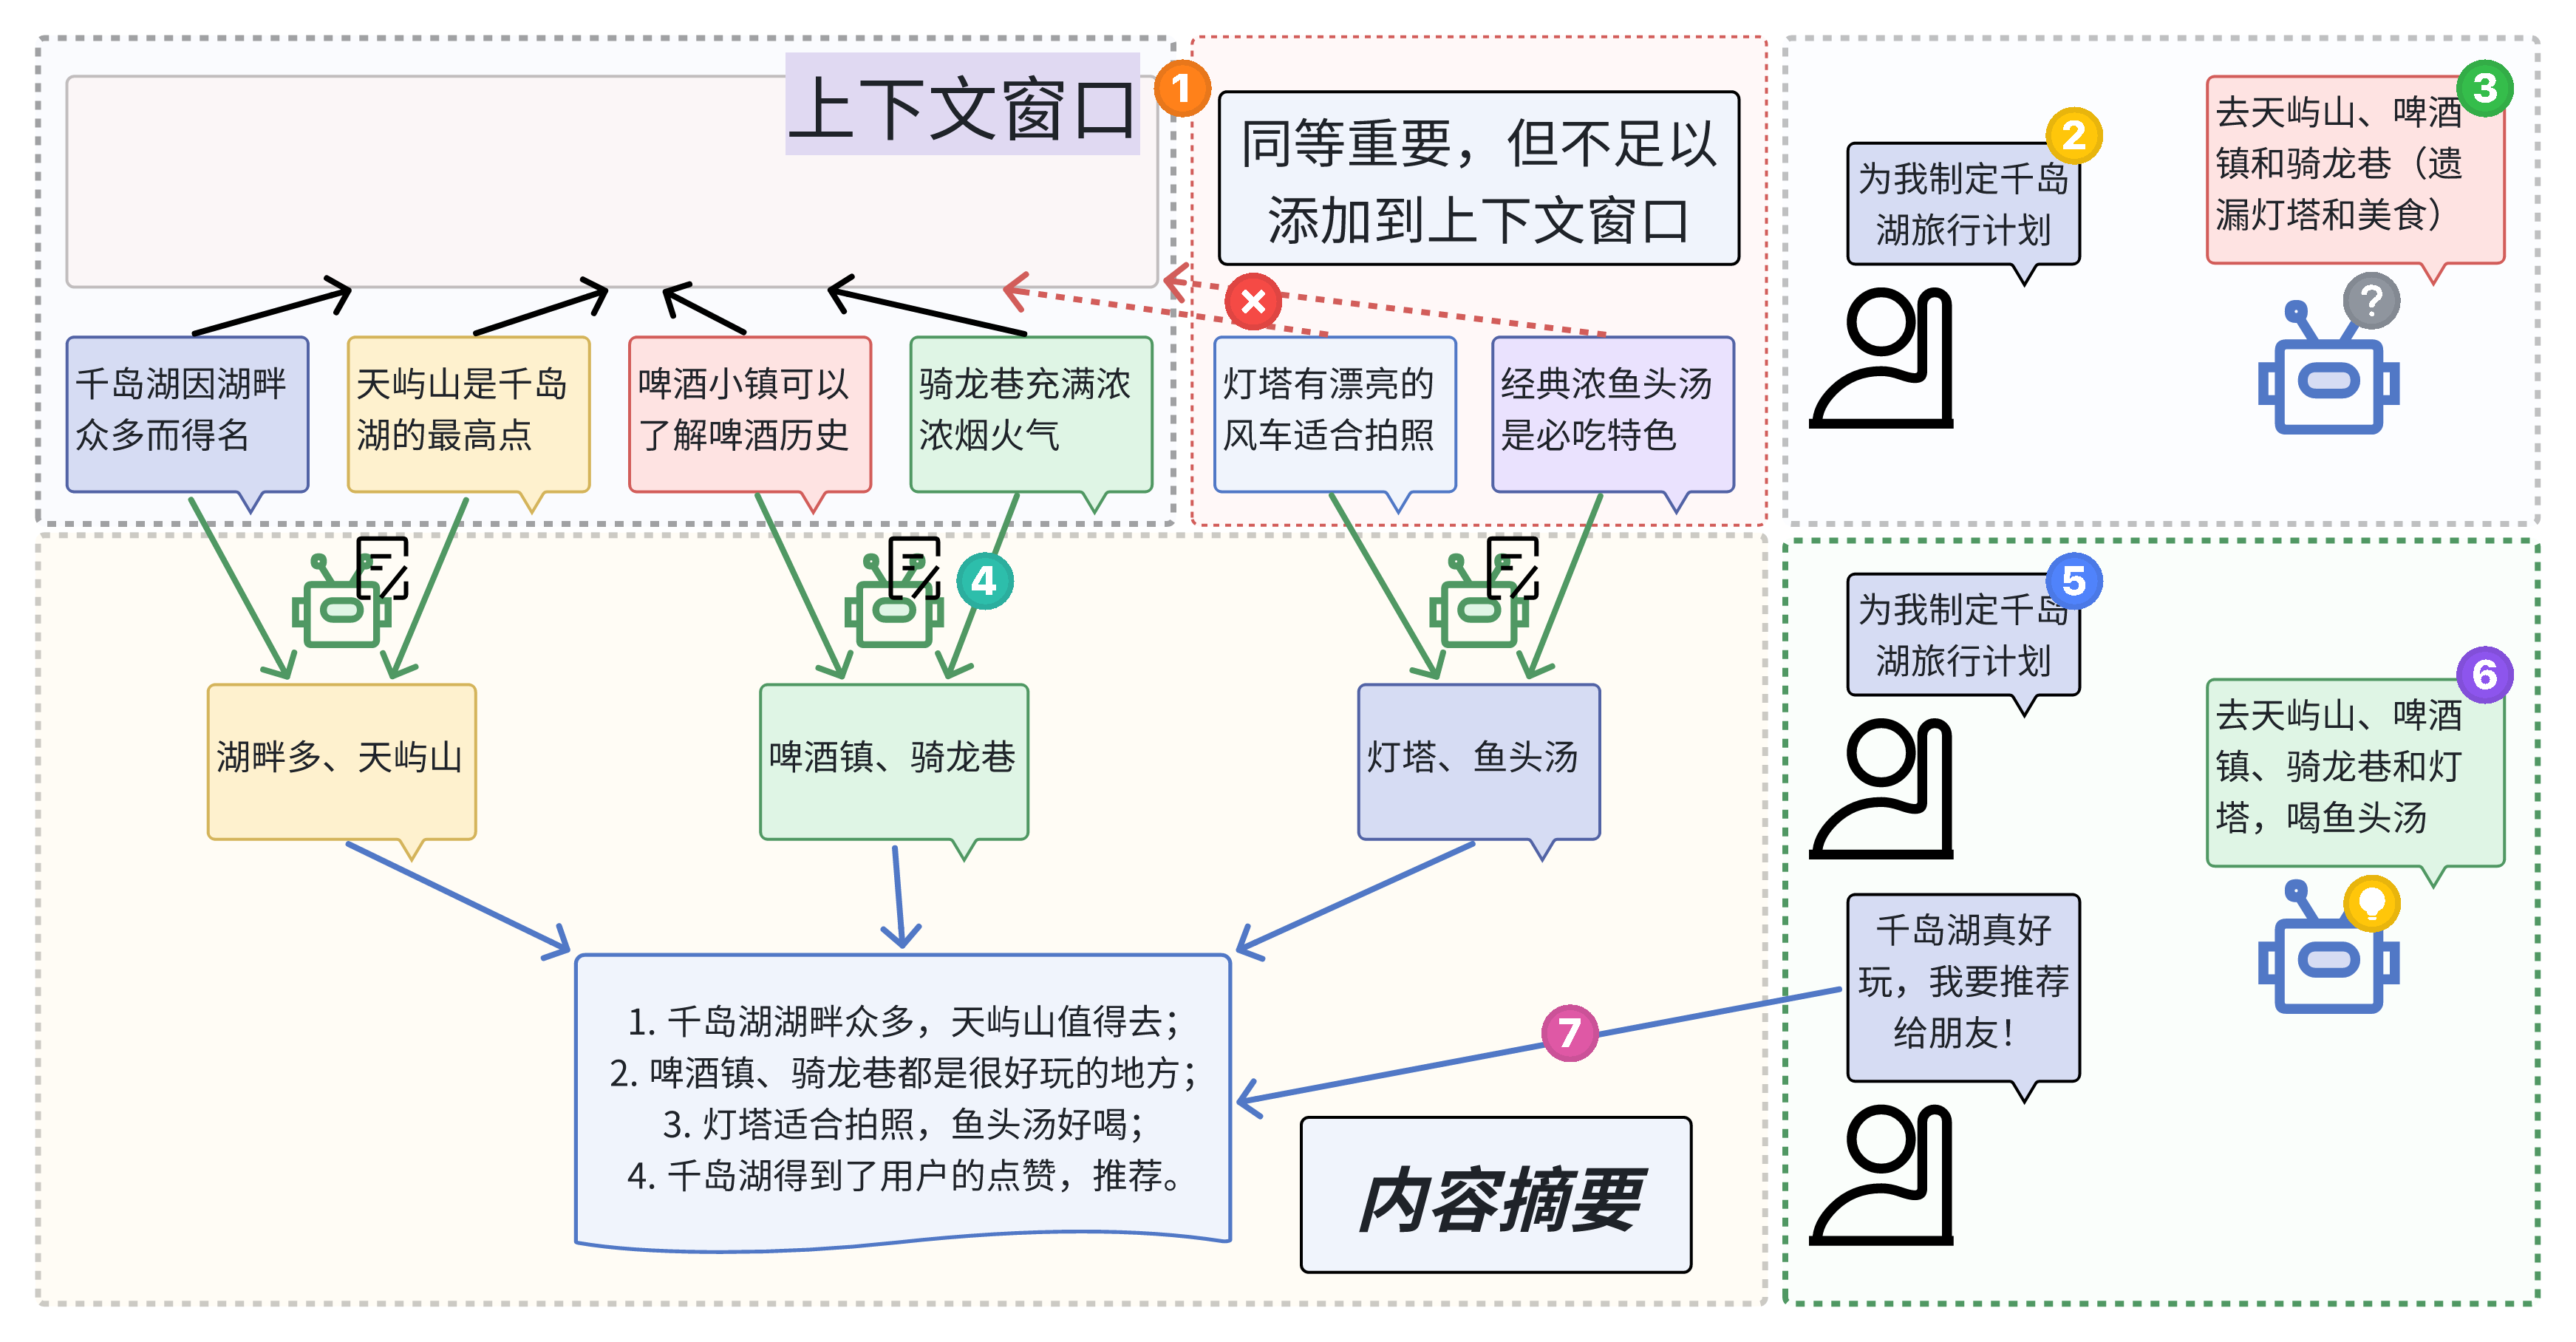
&#x20;*图6.3 对话摘要式记忆管理流程示意：较早的对话经过LLM总结提炼为“摘要记忆”，与当前对话内容一起送入模型产生回答。随后，可将新的重要信息再融入摘要，循环迭代。通过这种机制，模型既拥有有限的即时记忆（短期窗口），又有浓缩的长期记忆支持。*


## 6.5 检索增强生成（RAG）方法

在实际应用中，大语言模型（LLM）常面临知识范围有限、实时性不足的问题。**检索增强生成**（*Retrieval-Augmented Generation*, **RAG**）方法通过引入外部“**知识库**”，让模型在回答问题时可以检索相关信息作为参考，从而提高答案的准确性和时效性。本节将详细介绍 RAG 的实现方法，包括如何构建知识库、进行相似度检索、将检索结果增强到上下文，以及在对话过程中动态更新知识库的机制。实际上这部分内容就是对长期记忆的更近一步的阐述，本节会用一个简单的demo让同学们熟悉一整套RAG的流程。

### 6.5.1 构建知识库

RAG 的第一步是构建一个可供检索的**知识库**。知识库本质上是对文本等非结构化数据的向量化存储，即将大量文本文档转换为**嵌入向量**（Embeddings）并建立索引，以支持后续的高效相似度检索。引入Embedding这一概念的原因是：文字对人类有意义，但对计算机来说，只是字符串；我们想让计算机理解它们之间的关系，这就需要把文本转换为计算机能理解的数值。因此，所谓Embedding就是把一个词（或句子、图像等）转化成一个向量（一串数字），而且这些数字是有“意义”的——对于相似的文本得到的嵌入向量，其在该向量空间里的距离应该近一些；反之语义相关度低的文本得到的嵌入向量，在该向量空间里的距离就会远一些。


为了具体理解这一概念，我们考虑一个简单的例子：只考虑“小猫”、“小狗”、“苹果”这三个词，一种可能的嵌入向量是：
+ 小猫 ---> [1.0, 1.0]
+ 小狗 ---> [0.9, 1.1]
+ 苹果 ---> [-1.0, -1.0]

在二维平面里，小猫和小狗对应的二维向量较为接近；而苹果作为水果，应该与小动物距离较远。这就是嵌入向量的意义。此外，本节不会详细讲解生成嵌入向量的算法，感兴趣的同学可以自行去查阅相关资料。

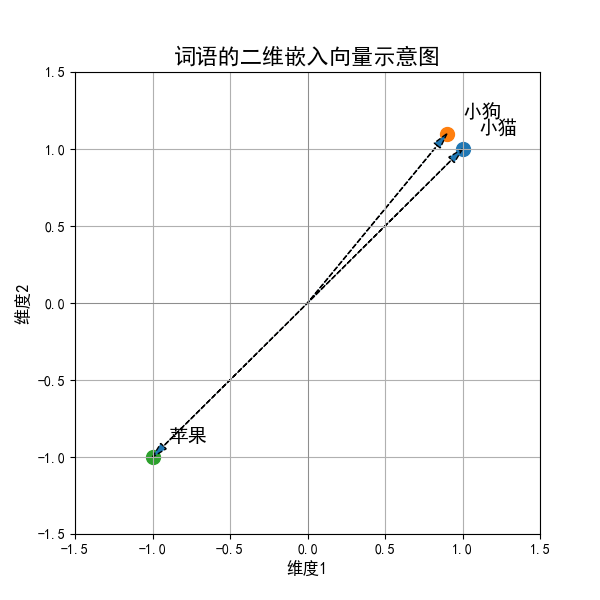

*图6.4 可视化了这三个词语的嵌入向量，可以发现小猫小狗较为接近，而苹果距离较远。*
   


在实践中，我们通常需要对原始文档进行适当的**预处理**和**切分**。例如，移除文档中的噪音符号，按段落或固定长度对长文档分块等，使每个片段的长度适合嵌入模型的输入限制（如512字符以内）。这样既可提高嵌入表示的质量，也能提升检索的精细度。完成预处理后，就可以使用 Sentence-Transformers 提供的模型将文本转为向量。本节将通过一段示例代码演示完整的向量化与索引构建流程。例如，我们有两段示例文档文本，它们介绍了“PolarDB for AI”产品的相关信息。下面的代码展示如何使用 `sentence_transformers` 库加载预训练嵌入模型，将文档文本转换为向量，并使用 FAISS 库构建向量索引：

### 实验6-6 文档向量化，并构建向量索引

In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss


import os

# 设置为 Hugging Face 官方源
os.environ["HF_ENDPOINT"] = "https://huggingface.co"


# 示例文档文本
doc1 = """PolarDB for AI是基于PolarDB MySQL版的数据库内分布式机器学习组件。
它提供了通过SQL语句进行机器学习模型训练、评估和推理的能力，并内置分类、回归、聚类等多种算法。
PolarDB for AI 打通了数据库和AI应用之间的壁垒，为数据驱动的智能应用提供了一站式的高效方案。"""

doc2 = """PolarDB for AI 将传统的数据库+AI模式转变为一站式的智能应用。
基于PolarDB for AI的推荐算法和知识图谱技术，企业可以针对不同业务场景定制个性化解决方案，
快速完成冷启动并持续提升核心业务指标。"""

docs = [doc1, doc2]

# 1. 加载预训练嵌入模型（如中文 BGE-base 或 MiniLM）
model = SentenceTransformer('BAAI/bge-large-zh-v1.5')  # BGE-base-zh 模型适用于中文
# 2. 将文档列表转换为嵌入向量
embeddings = model.encode(docs)  # 返回形如 (len(docs), dim) 的numpy数组

# （可选）如果使用内积作为相似度度量，先对向量进行单位化，以便内积数值表示 cosine 相似度
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
print(f"两个文本对应的嵌入向量分别是：{embeddings}")


dim = embeddings.shape[1]  # 向量维度
# 3. 创建 FAISS 索引并添加向量
index = faiss.IndexFlatIP(dim)  # 使用内积度量的平lat索引
index.add(embeddings)

print(f"索引中的向量数: {index.ntotal}")

两个文本对应的嵌入向量分别是：[[ 0.03606219  0.03045189  0.02631436 ... -0.01832789  0.03622741
   0.01211706]
 [ 0.0538147   0.03196371  0.01776999 ... -0.03637151  0.03823718
   0.00666482]]
索引中的向量数: 2


上述代码分三步完成了知识库构建：（1）加载预训练的中文句向量模型，例如 bge-large-zh-v1.5（由北京智源研究院提供的通用文本嵌入模型）以获取高质量的文本向量表示；（2）调用模型的 `encode` 方法将文档列表转为嵌入向量数组；（3）使用 FAISS 建立向量索引，这里我们选用简单的内积索引（`IndexFlatIP`），并将所有文档向量添加进去。内积（IP）索引用于计算向量的点积，相当于衡量向量夹角余弦相似度（在已单位化向量的前提下）。代码最后打印了索引中的向量数以确认构建成功。

通过以上步骤，我们已将文本知识库转化为向量索引结构。这个**知识库索引**支持后续基于语义相似度的快速检索。当知识库规模较大时，可以考虑使用 FAISS 提供的其他索引类型（如 `IndexIVFFlat`, `IndexHNSW` 等）来加速检索，但在本示例中，我们以最简单的平面索引演示概念。构建好的知识库索引可以持久化保存，以便在应用运行时加载用于查询。至此，RAG 的知识库部分准备就绪。

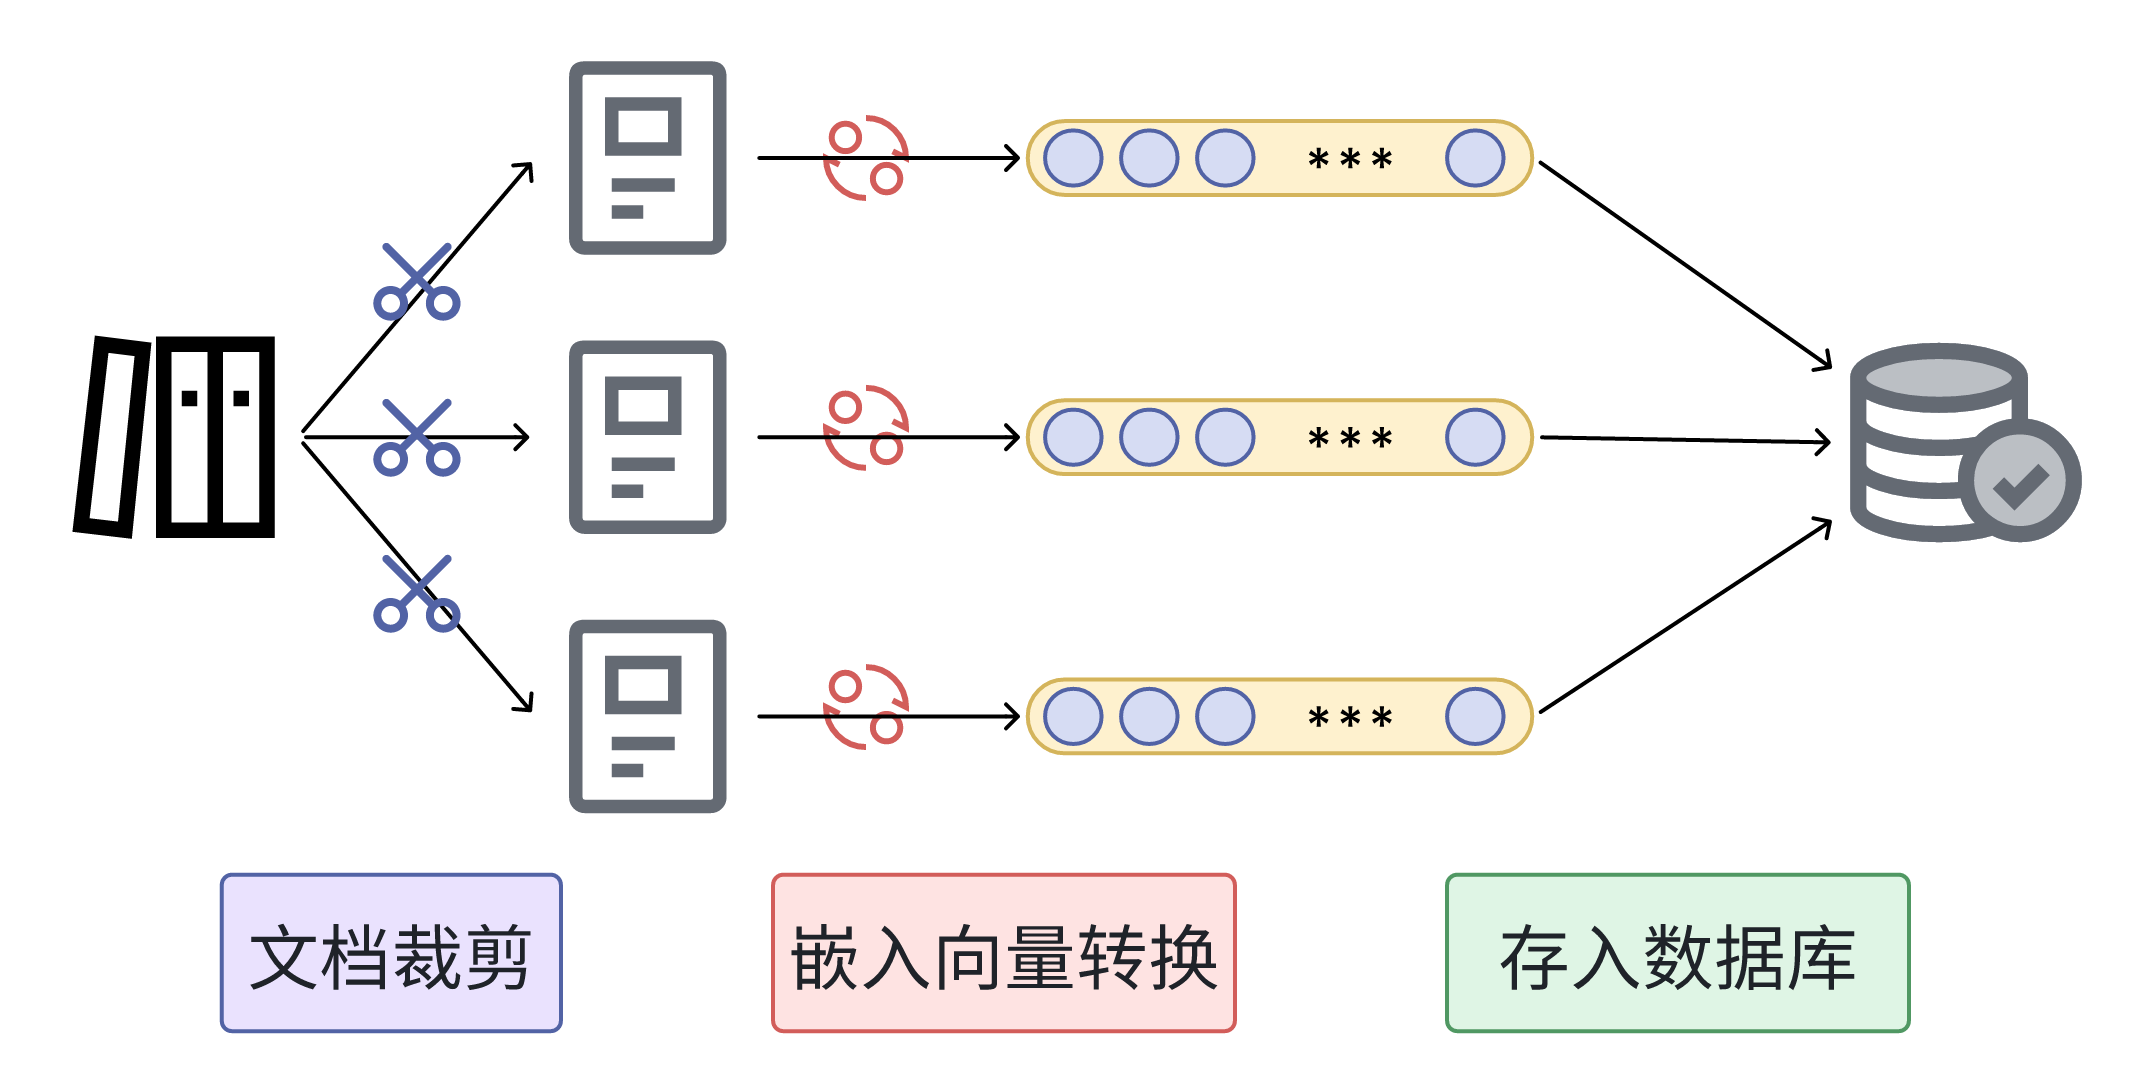
*图6.5 展示了 RAG 管道中知识库构建和检索的流程：首先通过数据加载和处理，将原始文档转为适合嵌入模型的文本；接下来使用预训练的文本嵌入模型（如 Sentence-Transformers 提供的 BGE-base-zh、MiniLM 等）将文档转为向量表示；然后将这些向量存入向量数据库或索引结构中。至此，知识库中的每条知识都对应一个高维向量，代表了其语义信息，支持后续的相似度查询。*


### 6.5.2 相似度检索

完成知识库向量索引后，当用户提出问题时，系统需要将**查询**转化为向量并执行**相似度检索**，找出知识库中最相关的内容片段。常用的计算相似度的方法有如下几种：
1. **余弦相似度**（Cosine Similarity）：这是一种衡量两个向量方向相似程度的方法，其计算公式为：

$$
\text{CosineSimilarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \cdot \|\mathbf{B}\|}
$$

其中 $ \mathbf{A} \cdot \mathbf{B} $ 是点积，$ \|\mathbf{A}\| $ 和 $ \|\mathbf{B}\| $ 是向量的模长。该值介于 \([-1, 1]\)，越接近 1 表示两个向量越相似，适用于文本向量等语义匹配场景。

2. **向量距离**（Vector Distance）是另一类衡量相似度的方法，常见的包括：

- **欧几里得距离**（Euclidean Distance）：衡量两点间的实际空间距离，公式为  
  $$
  \text{EuclideanDistance}(\mathbf{A}, \mathbf{B}) = \sqrt{\sum_{i=1}^{n}(A_i - B_i)^2}
  $$

- **曼哈顿距离**（Manhattan Distance）：衡量各维度差值的绝对和，公式为  
  $$
  \text{ManhattanDistance}(\mathbf{A}, \mathbf{B}) = \sum_{i=1}^{n} |A_i - B_i|
  $$




在文本语义检索任务中，余弦相似度最为常见，因为它更关注语义方向上的相似性，而不受文本长度影响；而在图像处理或物理空间建模等场景中，欧几里得距离和曼哈顿距离也有广泛应用。
  
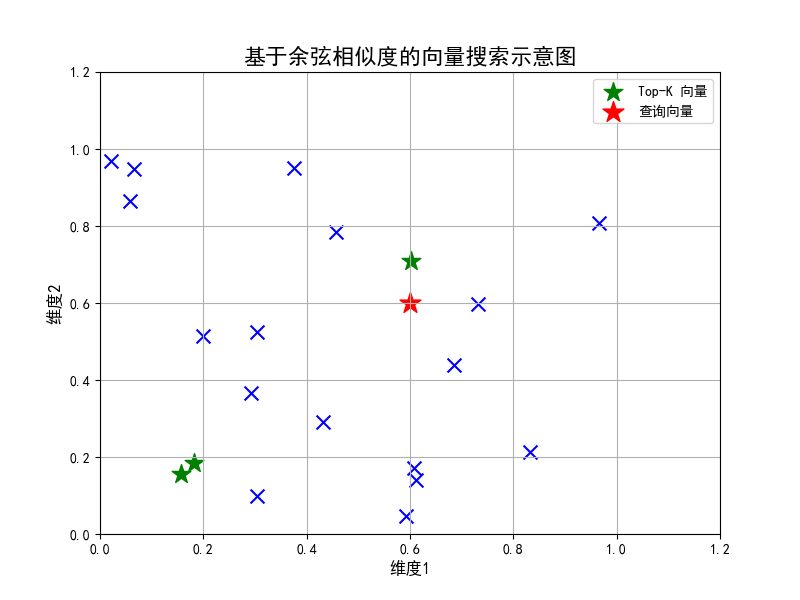

*图6.6直观展示了查询向量与文档向量的余弦相似度搜索过程。 其中，红色星形表示用户查询的向量，蓝色叉号表示知识库中的文档向量。通过计算向量空间中的余弦相似度，可以找到夹角最小的若干文档（绿色 X 标记的点即 Top-K 邻近向量），这些即为与查询语义最相关的内容。*


实际检索流程如下：首先，将用户输入的问题（或对话中的上一轮询问）经过与构建知识库相同的嵌入模型编码，得到查询的向量表示；然后，利用 FAISS 索引的搜索功能，在向量空间中找出与查询向量最相似的几个文档向量。FAISS 提供了高效的 `index.search(query_vector, k)` 方法，一次性返回最相似的 *k* 条向量及其相似度分数。例如，针对上节构建的示例知识库，如果用户问题是“**PolarDB for AI 提供了哪些功能？**”，我们可以执行以下代码进行相似度检索：

### 实验6-7 利用FAISS进行相似度检索

In [8]:
# 将用户查询转换为向量（假设 model 已加载）
query = "PolarDB for AI 提供了哪些功能？"
query_vec = model.encode([query])
query_vec = query_vec / np.linalg.norm(query_vec, axis=1, keepdims=True)  # 单位化

# 在索引中搜索与查询向量最相似的 Top2 文档
D, I = index.search(query_vec, k=2)  # D 是相似度分数数组，I 是索引编号数组

for rank, idx in enumerate(I[0]):
    score = D[0][rank]
    print(f"相关文档 {rank+1}: 索引={idx}, 相似度分数={score:.4f}")
    print(f"内容摘录: {docs[idx][:50]}...")

相关文档 1: 索引=0, 相似度分数=0.8241
内容摘录: PolarDB for AI是基于PolarDB MySQL版的数据库内分布式机器学习组件。
它提供...
相关文档 2: 索引=1, 相似度分数=0.7812
内容摘录: PolarDB for AI 将传统的数据库+AI模式转变为一站式的智能应用。
基于PolarDB ...


在上面的代码中，我们将用户问题编码为 `query_vec`，并对其单位化以便使用内积作为相似度度量。然后调用 `index.search` 请求返回最相关的 2 条文档。函数将返回一个分数矩阵 `D`（表示相似度得分）和对应的文档索引矩阵 `I`。我们遍历输出每条结果的索引和分数，并从原始文档列表中打印内容片段进行验证。

实际上，我们的知识库中第一条文档（索引0）详细列出了 PolarDB for AI 的功能，第二条文档（索引1）侧重于应用场景。可以看到，文档0获得了更高的相似度（0.8241），表明它与查询**提供了哪些功能**语义相关度最高，文档内容正好罗列了PolarDB for AI的功能细节。文档1虽然也相关（可能提及应用场景），但得分稍低。通过这种相似度检索，我们成功找出了能够回答用户问题的知识片段。

> **调节 Top*K* 和阈值：** 在相似度检索过程中，有两个重要参数需要调节：一是返回结果数量 *K*（Top*K*）；二是设定最低相似度阈值。增加 *K* 可以获取更多候选知识，有助于在后续生成时提供更全面的信息，但过大的 *K* 也可能引入不相干的内容，增加模型处理负担。设定相似度**阈值**则可以过滤掉不相关的结果——例如只采用相似度分数高于0.8的文档。然而阈值过高可能导致没有任何结果通过筛选，从而模型缺乏外部信息支持。因此实际应用中需要根据知识库规模和质量来平衡选择：在知识库涵盖面较广时，可适当提高阈值保证精确性；而当知识库内容有限或查询可能找不到完美匹配时，降低阈值或至少返回1-2条结果以供参考会更稳妥。总之，应结合调试不断调整 *K* 和阈值，使检索既保证相关性又不遗漏潜在有用的信息。


### 6.5.3 增强上下文

通过相似度检索得到相关知识后，我们便可以将这些**检索到的内容片段**整合进 LLM 的输入，从而实现**检索增强生成**。具体方法是将检索结果作为**上下文**附加到用户的提问上，一并喂给大型语言模型，使其在生成答案时参考这些外部知识。这一步通常称为**提示增强**（Prompt Augmentation），即在提示信息中注入额外的知识。

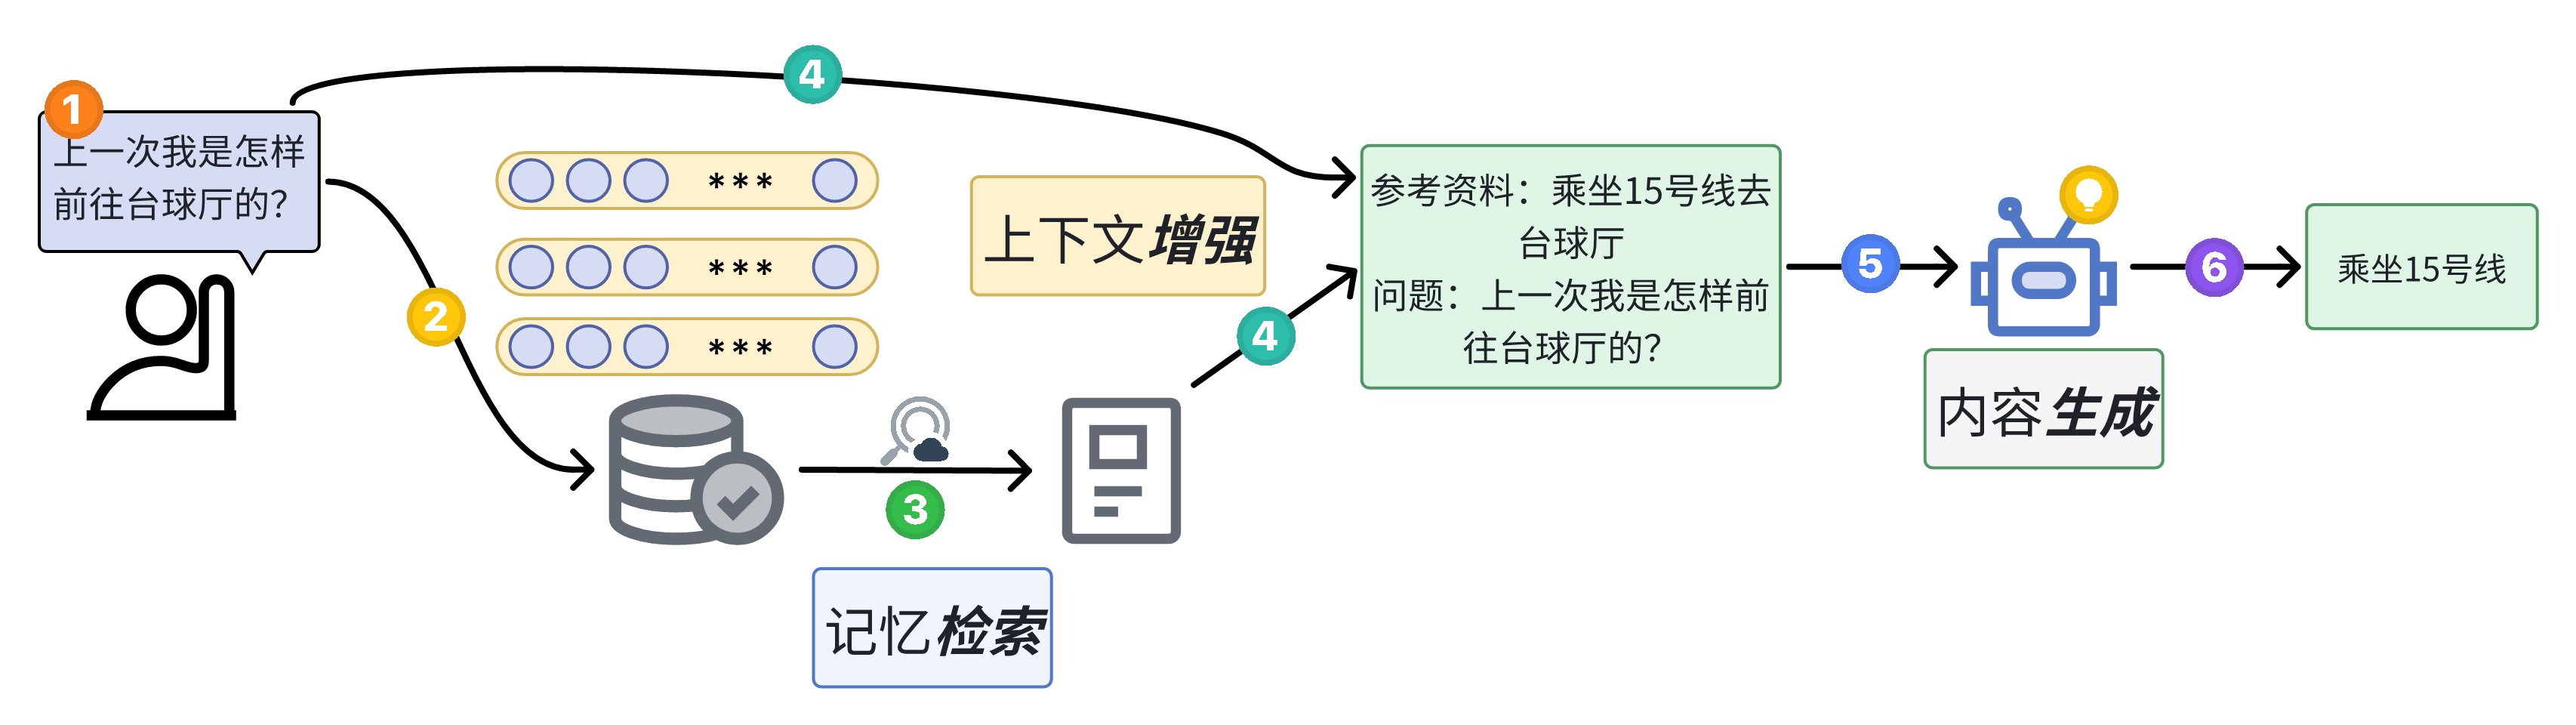

*图6.7：RAG 系统在收到用户提示后，会由检索模块查询内部知识源，找到相关的数据（步骤1和2），然后将原始提示与检索到的内容合并形成“增强提示”（步骤3），最后传给生成模型LLM进行回答（步骤4）。这样，LLM 可以依据附加的事实材料来生成更加准确和详实的回答。*

在实践中，有多种方式可以将检索结果嵌入到提示中。常见做法是构造一个固定的提示模板，例如：

```
请根据以下提供的参考资料，回答用户的问题。

参考资料：
[文档1] {检索到的文本片段1}
[文档2] {检索到的文本片段2}
...

问题：{用户的问题}
请基于参考资料给出详细的解答：
```

在上述提示模板中，“参考资料”部分列出了检索到的段落（可以对每段加编号或来源标识），接下来是用户的实际问题，最后要求模型“基于参考资料详细作答”。通过明确指示模型只参考提供的资料，能够有效减少模型**幻觉**（臆造不实内容）的概率。提示的格式设计对RAG效果影响很大——清晰的结构和指令有助于模型理解哪些内容是知识依据、应该如何在答案中引用它们。

下面我们以本节前述的示例为例，演示增强上下文对LLM回答的影响。假设用户问题仍是“PolarDB for AI 提供了哪些功能？”，我们将调用开源的 Qwen2.5-7B-Instruct 模型进行回答，对比在**不提供检索资料**和**提供检索资料**两种情况下模型回答的差异。首先，不提供任何外部知识，仅凭模型自身知识库回答：

### 实验6-8 无增强上下文的知识回答

In [9]:
import torch
torch.manual_seed(423)  # 设置种子，确保实验可复现

RAG_agent = QwenAgent()

question = "PolarDB for AI 提供了哪些功能？"
# 模型直接回答（无增强上下文）
messages = [
    {"role": "system", "content": RAG_agent.system_prompt},
    {"role": "user", "content": question}
]
print(RAG_agent.ask(messages))


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


PolarDB for AI 是阿里云推出的一种专门为机器学习和深度学习场景设计的数据库服务，它结合了 PolarDB 的高性能关系型数据库能力和阿里云的 AI 技术。PolarDB for AI 主要提供了以下功能：

1. **自动模型训练与优化**：PolarDB for AI 能够自动执行模型训练过程，并根据数据集的特点自动选择最优的模型架构和参数配置。

2. **在线推理加速**：通过优化查询处理路径和利用高性能计算资源，PolarDB for AI 可以提供快速的在线推理能力，支持实时或近实时的数据分析需求。

3. **大规模并行处理**：支持大规模数据集上的并行处理，能够高效地处理 PB 级别的数据量，适用于大规模训练任务。

4. **集成的 AI 工具链**：内置多种常用的机器学习库（如 TensorFlow、PyTorch 等），方便用户直接在数据库中进行模型开发和训练。

5. **自动化管理**：包括自动扩缩容、自动故障恢复等功能，确保服务的稳定性和高可用性。

6. **安全合规**：遵循严格的隐私保护和数据安全标准，支持加密存储和传输，保障用户数据的安全。

7. **成本效益**：通过高效的资源利用率和按需付费的商业模式，帮助客户降低使用 AI 服务的成本。

请注意，具体的功能可能会随着产品版本更新而有所变化，请参考官方文档获取最新信息。


可以看出，没有参考资料时模型给出的回答基于其训练知识进行推测，内容可能比较泛泛，甚至不一定准确全面（例如模型可能不知道具体细节，就给出了一些模糊的功能描述）。接下来，我们将检索到的参考资料嵌入提示，再让模型回答同样的问题：

### 实验6-9 有增强上下文的知识问答

In [10]:
# 构造包含检索资料的提示
retrieved_info = docs[0]  # 假设取回文档0内容作为参考
enhanced_prompt = f"""请根据以下提供的参考资料，回答用户的问题。

参考资料：
{retrieved_info}

问题：{question}
请基于参考资料给出详细的解答："""

messages = [
    {"role": "system", "content": RAG_agent.system_prompt},
    {"role": "user", "content": enhanced_prompt}
]

# 模型在增强提示下回答
print(RAG_agent.ask(messages))

RAG_agent = None
import gc
gc.collect()  # 清理 Python 的垃圾对象
torch.cuda.empty_cache()  # 释放 PyTorch 缓存显存

PolarDB for AI 提供了以下功能：

1. 通过 SQL 语句进行机器学习模型训练：用户可以通过标准的 SQL 语法来编写机器学习模型的训练过程，使得模型开发更加便捷和直观。

2. 通过 SQL 语句进行机器学习模型评估：用户可以利用 SQL 语句对训练完成后的模型进行性能评估，确保模型在实际应用中的有效性。

3. 通过 SQL 语句进行机器学习模型推理：用户能够使用 SQL 语句将模型应用于新的数据集上，以实现对新数据的预测或分析。

4. 内置多种机器学习算法：PolarDB for AI 集成了分类、回归、聚类等常见的机器学习算法，帮助用户快速搭建各种类型的模型。

5. 数据库与 AI 应用之间的无缝集成：PolarDB for AI 通过打通数据库与 AI 应用之间的壁垒，让用户能够在统一的平台上完成从数据准备到模型训练再到结果输出的全流程操作，简化了开发流程。

6. 提供一站式高效解决方案：PolarDB for AI 旨在为数据驱动的智能应用提供全面的支持，包括但不限于数据处理、特征工程、模型训练与优化等各个环节，帮助用户快速构建智能化的应用程序。


可以看到，增强上下文后模型的回答紧密围绕参考资料展开，列举了PolarDB for AI的具体功能点，内容详实且准确。这验证了 RAG 方法的效果：**通过检索增强，LLM 能利用外部知识库来产生超出其原有训练范围的准确回答**。在这个过程中，**提示设计**发挥了关键作用——我们明确提供了“参考资料”并要求“基于资料回答”，模型于是将资料中的要点融入回答，避免了主观猜测，从而极大降低了回答的错误率。

需要注意的是，将检索内容拼接进提示会增加提示的长度，占用一定的 token 空间。在实际应用中应权衡检索内容的数量和详略，尽量筛选出精炼的知识片段。对于非常长的检索结果，可以考虑在提示中让模型先总结资料要点，再据此回答用户问题，从而节省 token。随着对话轮次增加，开发者也可以采取**摘要压缩**、**信息筛选**等策略控制提示长度。总之，增强上下文的信息应当**相关且适量**，既包含回答所需的关键事实，又不过多干扰模型生成流程。

### 6.5.4 记忆更新机制

RAG 系统不仅可以利用现有知识库检索回答问题，还应该具有**动态更新**知识的能力。当对话进行过程中出现新的有用信息（例如用户提供了一段新知识，或者模型从外部查询得到了更新数据），我们希望将这些新知识**写入长期知识库**，以便后续轮次或下次会话也能检索到它。这就需要设计一种**记忆更新机制**：判断何时、如何将对话中新产生的知识添加到知识库，并如何处理旧知识的淘汰或更新。

**(1) 新知识写入：** 在每次用户交互后，系统可以分析模型的回答和用户提供的信息，判断其中是否含有知识库尚未存储的新事实。如果有，则将该内容整理成合适的文本片段，通过与6.5.1节相同的流程生成嵌入向量，并添加到现有向量索引中。


**(2) 知识去重：** 添加新知识前应检查是否与知识库中现有内容重复。如果重复存储相同或相似的信息，会导致检索结果冗余甚至影响模型判断。简单的做法是对新知识计算嵌入后，与当前索引向量做一次相似度搜索，看看是否已有足够相近的向量（例如余弦相似度 > 0.95）。若是，则可认为知识已存在而不必重复添加；若没有，则安全添加。

**(3) 知识过期与淘汰：** 随着时间推移，知识库中的部分内容可能变得陈旧过时（例如产品旧版本的信息）。我们可以在知识元数据中引入“有效期”或“更新时间”标签。一旦某条知识被标记为**过时**，检索时应降低其优先级或在检索结果中过滤掉。此外，可以定期审查知识库，手动或自动移除明显失效的条目。例如，通过维护一个索引映射，删除某些ID对应的向量（FAISS的某些索引支持删除操作；若不支持则需要重建索引来彻底移除）。

**(4) 定期重建索引：** 当知识库经历了多次增删改操作后，建议定期重建向量索引。一方面，某些近似索引结构在大量动态更新后性能可能下降，通过重新构建可以重新优化向量分布以提升检索准确率；另一方面，重建索引时可顺便剔除被标记过时的知识，从而保持知识库的“新鲜度”。重建频率取决于系统对实时性的要求和更新频率，对于日积月累增长的知识库，或许每隔固定周期（如每周、每月）进行一次全量向量重建是稳妥的策略。

通过上述记忆更新机制，RAG 系统能够不断学习累积新的知识，使其知识库与时俱进。需要平衡的是对话系统的即时响应性能与后台知识更新的开销：小批量的知识添加可以实时完成，但大规模的索引重构最好安排在系统空闲时段异步进行。总体而言，**RAG的强大之处在于结合了信息检索的灵活扩展性和生成模型的语言理解与表达能力**。掌握了本节介绍的知识库构建、相似度检索、上下文增强以及记忆更新方法，开发者就能够搭建出一个具备“长短期记忆”的智能对话代理，让大模型在特定领域知识的支持下发挥出更精准实用的价值。

## 6.6 实用技巧与注意事项
前面的内容里，我们已经全面了解了记忆机制（包括短期、长期记忆），也动手实践完成了检索增强生成的完整流程。在这一节中，我们会讲解一些实用技巧与注意事项，来帮助同学们更好地使用这两种技术。


### 嵌入模型与向量库选型

* **主流模型比较**：在中文语境下，BGE 系列（如 BGE-large-zh、BGE-base-zh）在检索效果上处于领先地位。研究显示，BGE-large（1024 维）在标准中文嵌入评测集 C-MTEB 上平均得分约为 63.96%，显著高于较老的 text2vec 基础版（768 维，约 48.59%）等。
* **速度与精度权衡**：小型模型（MiniLM、text2vec-base）每秒处理查询量高，如 text2vec-base-chinese 约 3000 QPS，适合高并发场景；大模型（BGE-large、text2vec-large）维度高、计算慢，但召回精度优异。例如，在 GPU 上 text2vec-large（1024 维）QPS 约 2092，其语义精度略优于 text2vec-base（768 维，QPS≈3008）。
* **场景适配建议**：对**短文本**（如 FAQ 问答、简短用户查询）可优选轻量模型（如 MiniLM、text2vec-base），兼顾响应速度和基本准确度；对**长文档或摘要**检索，可采用 BGE-large、text2vec-paraphrase 等高容量模型，后者专门增加了句子–段落匹配数据训练，善于处理长文本对齐；对**用户历史记忆**（对话、偏好）等中等长度文本，可根据需求平衡精度与速度，例如使用 text2vec-base-paraphrase 或 BGE-base 作为折衷方案。
* **技术选型表**（示例）：

  | 模型                               | 输出维度 | 特点与评测（中文环境）                               | 推荐场景               |
  | -------------------------------- | ---- | ----------------------------------------- | ------------------ |
  | BGE-large-zh                     | 1024 | 中文语义最好                                    | 长文档、高准确度需求（知识库、文档） |
  | BGE-base-zh                      | 768  | 性能优异，比传统模型强                               | 一般检索、用户记忆召回        |
  | text2vec-base-chinese            | 768  | 中文预训练 (MacBERT) 精度中等<br>推理 \~3008 QPS     | 常规语义匹配、聊天检索        |
  | text2vec-base-chinese-paraphrase | 768  | 加强段落匹配                                    | 长文本匹配、摘要检索         |
  | text2vec-large-chinese           | 1024 | 较高精度（近 text2vec-base）<br>推理 \~2092 QPS    | 高准确率场景、可容忍较慢查询     |
  | E5-base                          | 768  | 多语通用，中文召回 \~56.21%                         | 跨语言检索场景            |

  *(注：QPS ＝ 每秒查询量；表中精度指相对评测指标，参见文献https://arxiv.org/html/2309.07597v3#:~:text=OpenAI,02)*。

### 检索干扰与提示工程

* **错误召回案例**：RAG 系统中若检索阶段出现“误召回”（如检索到无关、过时或错误信息），生成阶段容易出现不可置信的结果。*案例*：如用户询问其话费情况时，若检索到包含其他用户账单的资料，模型可能给出错误答案。模糊的询问可能同时召回多个相互冲突的事实，模型若不加区分会生成混淆答案。这些现象背后的原因是：检索器对查询理解不足或数据噪声过多，导致**上下文与问题不匹配**，从而引发下游生成输出时的幻觉或不相关内容。
* **提示词策略**：为降低误导风险，可通过精心设计提示词来引导模型正确利用检索内容。典型的方法有如下几个：
  1. **明确提示与分隔上下文**：如在模板中清晰标识“检索到的信息”与用户输入（例如使用 `参考资料：... 问题：...` 的格式），帮助模型区分来源和问题。
  2. **上下文注释**：在提示中加入提醒，如“下列资料仅供参考”，或要求模型仅在检索到相关信息时回答，否则回答“不确定”，可避免盲目引用。
  3. **示例演示**：使用 few-shot 或 chain-of-thought 提示（提供参考示例或思考步骤）也有助于模型准确使用检索信息。总之，清晰具体的提示能显著减少歧义和泛化回答。

### 数据隐私与知识库存储策略

* **敏感数据处理**：对于长期记忆（用户对话、偏好等），必须采取隐私保护措施。一些常用的措施包括：
  1. **去标识化**：应在索引前对个人身份信息进行脱敏或加密处理，避免直接存储明文敏感数据。
  2. **加密存储**：向量数据库应启用存储加密（如 AES-256）和传输加密（TLS）。例如 Weaviate 企业版已支持静态与传输数据加密，并提供客户自管密钥选项。
  3. **访问控制**：对向量库访问实施严格的权限控制（身份验证和基于角色/令牌的授权）。在 Qdrant 中可使用令牌控制具体集合和数据子集访问；Weaviate 亦提供细粒度 RBAC（查看、写入权限审核日志）。上述措施确保只有授权用户才能检索和修改敏感内容。
  
* **向量存储对比**：常见开源向量数据库各有侧重：

  | 系统           | 加密支持           | 访问控制                    | 多租户/隔离                   | 典型应用场景          |
  | ------------ | -------------- | ----------------------- | ------------------------ | --------------- |
  | **FAISS**    | 无（纯索引库，无持久层）   | 无（依赖外部实现）               | 无                        | 科研、高性能近邻检索（需自建） |
  | **Weaviate** | 支持（TLS & 静态加密） | 支持（RBAC 角色权限）           | 支持（GraphQL 模型、Class 级隔离） | 知识图谱搜索，企业级合规应用  |
  | **Qdrant**   | 支持 TLS（可选配置）   | 支持（令牌访问，按集合/Payload 限制） | 支持（基于过滤的粗粒度隔离）           | 高并发相似度检索，强过滤需求  |
  | **Chroma**   | 无内置加密          | 原生无认证（1.0.10 之前需代理实现）   | 无（建议通过多库或外部隔离）           | 开发友好、小规模原型项目    |

  *(注：上表来自公开文档和评测。FAISS/Chroma 本身不包含完善的安全特性，需要额外部署策略。)*
* **容量规划与清理机制**：教学环境通常规模较小（<1 万条数据）时可使用简单方案；但任何生产级 RAG 系统都应做好扩展准备。一般可按以下原则规划：

  1. **存储估算**：768 维向量约占 3KB（浮点32位）存储空间，百万级条目即数 GB 级别，应留足硬盘/内存空间。针对大规模数据，选用支持磁盘索引或分片的数据库（如 Milvus、Weaviate、Qdrant 集群）。
  2. **多库/分片设计**：可根据知识域（用户、主题等）拆分多个集合或库，实现逻辑隔离。比如将用户个人记忆与公共文档分开存储，便于权限控制与按需清理。
  3. **更新与清理**：对知识库设定更新策略。如文档更新时重新计算嵌入并上载（先删除旧条目再 upsert）；对长期未访问或过期的数据定期清理；对敏感信息可设置保留期限，到期自动丢弃。为防止索引膨胀，建议定期审查停用档或使用日志审计挖掘未使用的向量并清理。
  4. **监控与备份**：生产系统应监控数据库负载和容量，及时扩容，并做好快照备份以防数据损坏。Weaviate 企业版等提供**不可变备份**功能，可避免恶意或意外删除（参见HIPAA合规案例）。

通过上述方法，既可保证系统性能和可扩展性，又能满足教学与生产环境下的数据合规和安全需求。

## 6.7 实战：构建一个文档问答智能体
在本一节里，我们会把之前讲解的记忆与检索知识融会贯通，实战完成一个实用的文档问答智能体。接下来我们逐步完成这一套流程：

### 实验6-10 构建科技新闻文档问答智能体
本节选取的文档是机器之心在2025年6月30日发表的一篇科技论文解读，链接见https://www.jiqizhixin.com/articles/2025-06-30-11。接下来我们逐步按照**预处理文档--->构建向量索引--->编写智能体检索并回答的逻辑--->测试几个问题**的顺序完成智能体的构建。

### 预处理文档
得到一份文档后，我们需要先进行数据预处理。我们首先把科技报道里的文段复制粘贴到.txt文件中，得到容易处理的文件格式。接下来需要对文档进行分割，一种常用的方法是根据各种标点符号、换行符等进行拆分，但是这样较为粗糙，分割效果欠佳。因此，这里我们选用Langchain框架提供的文本切割功能，对文档进行智能化切分，具体代码如下：

In [11]:
import sys
import os

# 将父目录（也就是含有 Agent.py 的目录）加入 sys.path
sys.path.append(os.path.abspath('..'))

from langchain.text_splitter import CharacterTextSplitter

# 读取文本文件
with open("document.txt", "r", encoding="utf-8") as file:
    text = file.read()

# 初始化分割器
text_splitter = CharacterTextSplitter(
    separator="\n",     # 以换行符分段
    chunk_size=200,     # 每块最多200字符
    chunk_overlap=50    # 块之间重叠50字符
)

# 执行切分
texts = text_splitter.split_text(text)

# 查看结果
for i, chunk in enumerate(texts):
    print(f"Chunk {i}:\n{chunk}\n")

Created a chunk of size 202, which is longer than the specified 200
Created a chunk of size 245, which is longer than the specified 200


Chunk 0:
会“思考”的目标检测模型来了！IDEA提出Rex-Thinker：基于思维链的指代物体检测模型，准确率+可解释性双突破
在日常生活中，我们常通过语言描述寻找特定物体：“穿蓝衬衫的人”“桌子左边的杯子”。如何让 AI 精准理解这类指令并定位目标，一直是计算机视觉的核心挑战。现有方法常被两大问题困扰： 决策过程不透明 （“黑箱” 预测）和 拒识能力不足 （对不存在物体输出错误结果）。

Chunk 1:
最近， IDEA 提出全新解决方案 Rex-Thinker ，首次将人类思维中的 “逻辑推理链” 引入视觉指代任务，让 AI 像人一样分步思考、验证证据，在权威测评中不仅准确率显著提升，更展现出强大的 “知之为知之” 能力！
项目主页：https://rexthinker.github.io/

Chunk 2:
项目主页：https://rexthinker.github.io/
在线 Demo：https://huggingface.co/spaces/Mountchicken/Rex-Thinker
Demo论文地址：https://arxiv.org/abs/2506.04034
开源代码：https://github.com/IDEA-Research/Rex-Thinker

Chunk 3:
开源代码：https://github.com/IDEA-Research/Rex-Thinker
投稿人：Qing Jiang
投稿团队：IDEA-CVR
突破在哪？让 AI 学会 “思考三步走”
传统模型直接输出目标检测框，而 Rex-Thinker 创新性地构建了可解释的推理框架：

Chunk 4:
传统模型直接输出目标检测框，而 Rex-Thinker 创新性地构建了可解释的推理框架：
1. 规划 （Planning）拆解语言指令：“找到坐在乌龟上的人” → 分解为 “第一步找到乌龟 → 第二步判断每个人是否坐在乌龟上”

Chunk 5:
2. 验证 （Action）对每个候选目标（如 “Person 1”“Person 2”）逐步核对子条件， 每一步的分析都绑定图中具体区域 （比如 Person 1 就对应图中标号为 Person 的人） （见图 2）
3. 决策 （Summarization）汇总验证结果，输出匹配目标的坐标或声明 “

可以看出，文档被切分为18个片段，这是后续流程的基础。


### 构建向量索引


在完成文档切分后，我们使用中文嵌入模型（如 BAAI/bge-large-zh-v1.5）将每个文本片段编码为语义向量，并通过 FAISS 构建高效的向量索引，便于后续的相似度检索。查询时，系统会将用户问题同样转化为向量，并在索引中检索出与之最接近的几个文本片段，作为回答问题的知识依据。该过程为文档问答智能体提供了强大的语义理解与信息检索能力，是整个问答流程的核心。



In [12]:
from sentence_transformers import SentenceTransformer
import numpy as np

# 加载中文嵌入模型（如 BAAI 的 BGE 模型）
model = SentenceTransformer("BAAI/bge-large-zh-v1.5")  # 推荐用于中文RAG任务

# 假设 texts 是之前切分好的段落列表
embeddings = model.encode(texts, show_progress_bar=True)

# 单位化（用于余弦相似度检索）
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

import faiss

dim = embeddings.shape[1]  # 获取向量维度
index = faiss.IndexFlatIP(dim)   # IP = Inner Product（用于余弦相似度）
index.add(embeddings)

print(f"FAISS 索引已构建，共包含 {index.ntotal} 条向量。")


import pickle

# 保存向量索引
faiss.write_index(index, "doc_index.faiss")

# 保存原始文本块与顺序
with open("doc_chunks.pkl", "wb") as f:
    pickle.dump(texts, f)

print("索引和文档片段已保存。")


query = "这个智能体架构支持哪些能力？"
query_vec = model.encode([query])
query_vec = query_vec / np.linalg.norm(query_vec, axis=1, keepdims=True)

D, I = index.search(query_vec, k=3)  # 返回 top-3 结果

# 打印最相似的段落
for rank, idx in enumerate(I[0]):
    print(f"Top {rank+1} 相似片段（分数：{D[0][rank]:.4f}）:\n{texts[idx]}\n")


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]

FAISS 索引已构建，共包含 18 条向量。
索引和文档片段已保存。
Top 1 相似片段（分数：0.4632）:
模型结构：基于检索的检测多模态模型设计 + CoT 推理
如图 3 所示，Rex-Thinker 在模型设计上，采用了基于检索策略，即先通过一个开集检测模型提取出所有的候选框，然后将候选框输入到模型中，然后模型对每个候选框进行推理，最后再输出答案，具体而言每个步骤为：

Top 2 相似片段（分数：0.4489）:
最近， IDEA 提出全新解决方案 Rex-Thinker ，首次将人类思维中的 “逻辑推理链” 引入视觉指代任务，让 AI 像人一样分步思考、验证证据，在权威测评中不仅准确率显著提升，更展现出强大的 “知之为知之” 能力！
项目主页：https://rexthinker.github.io/

Top 3 相似片段（分数：0.4317）:
有了基础推理能力后，进入关键的 GRPO 强化学习阶段，进一步提升推理质量与可靠性。通过引入 F1 准确率奖励 + 格式规范奖励 ，让模型自我优化推理路径。这一机制避免了单一推理路径训练可能带来的过拟合问题，促进了模型在推理策略上的多样性和泛化能力。 最终，GRPO 不仅提升了模型的推理精度，还显著增强了面对陌生类别、复杂描述时的鲁棒性和抗幻觉能力。如下图所示，模型在未见过的类别（热狗）也具备推理能力



从运行结果可以看出，我们已经成功构建了索引，并且可以根据用户的输入检索最相关的片段。

### 编写智能体检索并回答的逻辑
在完成向量索引构建后，我们进一步编写智能体的问答逻辑。具体流程包括：首先将用户问题转化为向量，并在 FAISS 索引中检索出与之最相似的文档片段；随后将这些片段作为参考资料，与用户问题一同构造成提示词（Prompt），交由大语言模型生成最终回答。通过这一过程，智能体能够实现对指定文档内容的精准理解与回答，完成一个端到端的文档问答任务。

In [21]:
import faiss
import pickle
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
torch.manual_seed(423)  # 设置种子，确保实验可复现

# 载入向量模型（必须与构建索引时一致）
embedding_model = SentenceTransformer("BAAI/bge-large-zh-v1.5")

# 载入 FAISS 向量索引
index = faiss.read_index("doc_index.faiss")

# 载入原始文本块（与向量一一对应）
with open("doc_chunks.pkl", "rb") as f:
    doc_chunks = pickle.load(f)


def ask_doc_agent(question, agent, top_k=3):
    # 1. 查询向量化
    query_vec = embedding_model.encode([question])
    query_vec = query_vec / np.linalg.norm(query_vec, axis=1, keepdims=True)

    # 2. FAISS 检索
    D, I = index.search(query_vec, top_k)

    # 3. 获取最相关文档块
    retrieved_chunks = [doc_chunks[i] for i in I[0]]
    context = "\n\n".join(retrieved_chunks)

    # 4. 构造 Prompt
    prompt = f"""你是一个文档问答助手，请基于以下参考资料回答用户的问题。
                参考资料：
                {context}

                用户问题：{question}
                请用清晰、完整的中文回答。
            """

    # 5. 调用大模型生成答案
    messages = [
        {"role": "system", "content": agent.system_prompt},
        {"role": "user", "content": prompt}
    ]
    response = agent.ask(messages)
    return response


doc_qa_agent = QwenAgent()

# 测试提问
question = "这个智能体架构具备哪些关键能力？"
answer = ask_doc_agent(question, doc_qa_agent)
print(f"【问题】：{question}\n【回答】：\n{answer}")


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


【问题】：这个智能体架构具备哪些关键能力？
【回答】：
这个智能体架构具备以下几个关键能力：

1. **基于检索的多模态模型设计**：通过开集检测模型提取所有候选框，并对每个候选框进行推理，从而提高检测和推理的准确性。

2. **CoT（链式思维）推理能力**：模型能够逐步推理，通过图像依据逐步输出标准化JSON格式的目标坐标，这不仅提高了模型的可解释性，还增强了其推理的可信度。

3. **强化学习优化**：通过GRPO（目标导向的策略优化）强化学习阶段，模型可以自我优化推理路径，引入F1准确率奖励和格式规范奖励，避免过拟合，增强模型在面对陌生类别和复杂描述时的鲁棒性和泛化能力。

4. **处理新类别的能力**：模型经过训练后，在未见过的类别（如热狗）也能具备推理能力，显示出了强大的泛化能力。

5. **两阶段训练策略**：采用SFT（自监督 fine-tuning）冷启动和GRPO后训练的方式，确保模型具备强大的推理能力，模拟人类逐步思考的过程。


从运行结果可以看出，整套RAG的流程已经实现，智能体可以根据检索出的相关片段对用户问题进行精确的回答。

### 测试几个问题

最后，我们再编写几个问题，测试我们自己动手构建的智能体的文档问答能力：

In [22]:
q1 = "这篇文章提到的架构叫什么？是哪个机构提出的？"
print(ask_doc_agent(q1, doc_qa_agent))



这篇文章提到的架构名为Rex-Thinker，是由IDEA-Research提出的。Rex-Thinker采用了一种基于检索的检测多模态模型设计，并结合CoT（Chain of Thought）推理，创新性地构建了一个可解释的推理框架。


In [23]:
q2 = "这篇文章提出的架构的推理框架是怎样的？"
print(ask_doc_agent(q2, doc_qa_agent))

文章中提到的推理框架名为CoT（Chain of Thought），这是一种创新的可解释推理方法。其推理框架可以分为以下几个步骤：

1. **规划（Planning）**：将复杂的语言指令分解成一系列简单的子任务。例如，对于指令“找到坐在乌龟上的人”，可以分解为两个步骤：“第一步找到乌龟；第二步判断每个人是否坐在乌龟上”。

2. **验证（Action）**：针对分解后的每一个子任务进行具体的验证操作。在这个例子中，就是分别寻找图像中的乌龟和确认哪些人坐在乌龟上。

3. **总结（Summarization）**：将验证结果综合起来，得出最终的答案。在上述例子中，最终确定哪个人坐在乌龟上。

这种推理框架使得模型能够逐步解决复杂的问题，并且每一步都具有明确的意义，从而提高了模型的可解释性。


In [24]:
q3 = "简要介绍这篇文章提到的架构的训练流程"
print(ask_doc_agent(q3, doc_qa_agent))

根据文章内容，这篇文章提到的架构的训练流程如下：

1. **冷启动训练**：首先在名为 HumanRef-CoT 的数据集上进行监督微调（SFT）。这个阶段的主要目的是帮助模型掌握基本的推理框架和输出规范。
2. **GRPO-based 强化学习后训练**：在完成冷启动训练后，进行基于 GRPO（可能是某种强化学习算法）的后训练，以进一步增强模型的推理能力。

总结起来，整个训练流程分为两个阶段：首先是监督微调阶段，然后是强化学习优化阶段。


In [25]:
q4 = "这篇工作提出的数据集叫什么？有哪些特点?"
print(ask_doc_agent(q4, doc_qa_agent))

这篇工作中提出的数据集叫做 HumanRef-CoT。它具有以下几个特点：

1. 完整推理链：每条样本严格按照“规划（Planning）- 验证（Action）- 总结（Summarization）”的推理流程生成。
2. 多样化推理场景：覆盖了单目标、多目标、属性组合、空间关系、交互行为等多种复杂的描述场景。
3. 拒答样本：特别加入了无匹配目标的描述，以引导模型在必要时学会拒绝作答，从而提升模型的抗幻觉能力。
4. 首次系统性地引入了推理链标注，这为训练具有推理能力的视觉指代模型奠定了基础。


In [26]:
q5 = "本篇工作的实验结果中有哪些具体的提升？"
print(ask_doc_agent(q5, doc_qa_agent))

doc_qa_agent = None
import gc
gc.collect()  # 清理 Python 的垃圾对象
torch.cuda.empty_cache()  # 释放 PyTorch 缓存显存

本篇工作的实验结果显示，在加入思维链（CoT）监督后，模型在各项指标上都有所提升，特别是平均提升0.9点DF1指标，并且在“拒识”子集上的表现提升尤为明显，Rejection Score提高了13.8个百分点，这表明引入推理链显著增强了模型对“不存在目标”的识别能力。

此外，通过GRPO训练，模型的平均DF1指标进一步提升至83.5。相较于单一推理路径的监督学习，GRPO通过奖励机制引导模型探索更优的推理路径，从而在复杂场景下显著改善了模型的鲁棒性和判断准确性。


与原文档的信息比对，可以看出我们的文档问答智能体的回答十分精准，至此，我们成功开发了一个很有现实应用意义的智能体！

## 6.8 小结

本章围绕“记忆管理与检索增强”展开，系统介绍了如何让智能体具备“记住信息”和“根据记忆做出反应”的能力。我们从基础的短期记忆机制讲起，逐步过渡到长期记忆存储与向量检索的实践方法，最后构建了一个具备记忆管理能力的文档问答智能体。

本章核心知识点包括：

- **短期记忆与长期记忆的差异**：前者基于上下文窗口即时存储，后者依赖外部数据库持久化信息。
- **Embedding 的生成与使用**：如何将自然语言文本编码为向量，以及如何用向量进行相似度检索。
- **向量数据库（如 FAISS）的集成**：通过构建检索增强生成（RAG）系统，使智能体能够调用“记住”的信息辅助回答。
- **记忆的注入与提取流程**：包括信息写入、相似度搜索、上下文拼接等操作。

通过本章的学习，同学们能够理解记忆系统在大模型智能体中的重要性，并掌握检索增强的完整流程，并利用这些技术开发一个具有现实应用意义的智能体。


## 6.9 参考文献
1. Lewis, P. et al. (2020). Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks. NeurIPS 2020. 
2. Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. EMNLP 2019.  
3. Chen, D. et al. (2017). Reading Wikipedia to Answer Open-Domain Questions. ACL 2017.  
4. Khandelwal, U. et al. (2020). Generalization through Memorization: Nearest Neighbor Language Models. ICLR 2020.  
5. Khattab, O., & Zaharia, M. (2020). ColBERT: Efficient and Effective Passage Search via Contextualized Late Interaction over BERT. SIGIR 2020.  
6. Mialon, G. et al. (2023). Augmented Language Models: a Survey. arXiv preprint.  
7. LangChain (2024). LangChain Documentation – Memory, Retrieval, and RAG. https://docs.langchain.com/


## 6.10 参考习题
### 选择题

**1. 以下关于“短期记忆”的说法正确的是：（）**

A. 一般指模型预训练期间的上下文

B. 通常是当前对话或最近几轮交互，可直接放入模型上下文

C. 长期保存在数据库中供未来检索

D. 只能通过检索机制才能访问

正确答案：B


**2. RAG（检索增强生成）方法的主要优势在于：（）**

A. 模型可以更快地产生回答

B. 所有生成内容均来自固定知识库，无需训练模型

C. 在生成前注入外部知识，提高内容准确性和时效性

D. 能直接替代向量数据库作为问答系统

正确答案：C

**3. 以下哪个不是处理长对话历史的常见策略？（）**

A. 使用多个模型并行处理

B. 对早期对话进行摘要压缩

C. 设置上下文窗口阈值，移除旧消息

D. 使用检索机制访问历史交互内容

正确答案：A

**4. 在使用 LLM 生成摘要以压缩长对话时，以下哪项做法最合适？（）**

A. 只保留每一轮中最长的句子

B. 将所有轮次拼接后直接截断到上下文窗口长度内

C. 使用 TF-IDF 提取高频词后拼接成摘要

D. 将原始内容分段，并引导模型提炼每段的关键信息

正确答案：D


### 判断题

**5. 长期记忆必须在每次对话前全部加载到 LLM 的上下文窗口中。**

正确答案：错误。长期记忆通常过大，不能全部放入上下文，应通过检索机制选择性加载。



**6. 使用余弦相似度和使用内积计算向量相似度是完全等价的。**

正确答案：错误。它们只有在向量单位化（归一化）后才等价，未归一化时结果不同。


**7. 一个向量索引构建后不可再添加新的向量数据。**

正确答案：错误。像 `IndexFlatIP`、`IndexHNSW` 等索引都支持动态增量添加向量。



### 简答题

**8. 简述长期记忆与短期记忆在智能体中的区别及其作用。**

参考要点：

* 短期记忆：指当前对话轮或最近交互内容，通常直接放入上下文窗口；
* 长期记忆：跨会话、长期积累的知识，如用户偏好、历史记录等，需使用独立存储和检索机制；
* 作用：短期用于维持上下文连贯性，长期用于增强智能体“个性化”与长期任务能力。



**9. 简述 RAG 系统中“检索错误配对”可能造成的问题，并举一个解决方法。**

参考要点：

* 问题：若检索内容与问题不匹配，模型可能生成误导性内容；
* 示例：用户询问“PolarDB 是否支持 PostgreSQL”，却检索到旧版说明；
* 解决方法之一：在提示中标明“参考资料仅供参考”，或要求模型“根据内容判断其适用性”。



**10. 查询资料，列举三个向量数据库，并分别指出它们在数据安全或多用户管理方面的能力。**

参考要点：

* **FAISS**：不支持原生加密或权限管理，仅适合离线使用；
* **Weaviate**：支持 TLS、RBAC、多租户、GraphQL 查询；
* **Qdrant**：支持 token 授权、过滤级访问控制、按集合管理；


### 实践题：
**11. 在6.4里，我们提到了基于重要性的记忆选择。而实验6-2中，我们实现了基于滑动窗口机制的短期记忆实现，现在，请你尝试把这里的滑动窗口机制调整为基于重要性的记忆选择机制，对比两种短期记忆实现机制的优劣**


参考要点：
* 滑动窗口机制实现简单，但是忽略了对话内容的重要性，仅仅关注最近的聊天内容，可能忽略重要信息；
* 基于重要性的记忆选择更加合理，可以确保记住关键信息，但需要额外考虑如何衡量对话内容的重要性。

参考代码：



In [2]:
import torch
import heapq
import gc

torch.manual_seed(423)  # 设置种子，确保实验可复现

# 假设这是你的对话智能体类
short_memory_agent = QwenAgent()

# 对话输入和人工打分（实际场景可由规则/模型打分替代）
user_queries_with_scores = {
    "你好，能跟我聊天吗？": 1,
    "你叫什么名字？": 2,
    "我喜欢编程，你呢？": 5,
    "你还记得我喜欢什么吗？": 1
}

# 系统提示初始化
system_prompt = {"role": "system", "content": short_memory_agent.system_prompt}

# 设置最大保留对话轮数（按重要性）
max_memory_pairs = 3  # 保留最多 3 对 user+assistant 的高分记忆
memory_heap = []      # 小根堆: (score, index, user_msg, assistant_msg)
global_index = 0      # 全局时间索引，用于排序稳定性

for query in user_queries_with_scores:
    score = user_queries_with_scores[query]

    print(f"------------------- 用户提问：{query} -------------------")
    
    # 构建模拟上下文（系统提示 + 当前保留记忆 + 当前用户问题）
    current_messages = [system_prompt]
    for s, idx, user_msg, assistant_msg in sorted(memory_heap, reverse=True):
        current_messages.extend([user_msg, assistant_msg])
    current_messages.append({"role": "user", "content": query})

    # 调用模型生成回复
    assistant_reply = short_memory_agent.ask(current_messages)
    user_msg = {"role": "user", "content": query}
    assistant_msg = {"role": "assistant", "content": assistant_reply}

    # 将这一对问答插入记忆池（重要性驱动）
    heapq.heappush(memory_heap, (score, global_index, user_msg, assistant_msg))
    global_index += 1

    # 超出最大容量则删除最不重要的一对
    if len(memory_heap) > max_memory_pairs:
        removed = heapq.heappop(memory_heap)
        print(f"删除低分记忆：{removed[2]['content']}（分数 {removed[0]}）")

    # 打印当前记忆池内容
    print(f"\n当前短期记忆（保留重要性Top{max_memory_pairs}对）：")
    for s, idx, umsg, amsg in sorted(memory_heap, reverse=True):
        print(f"- 用户: {umsg['content']}（分数 {s}）")
        print(f"  助手: {amsg['content']}")
    print("\n")

# 清理资源
short_memory_agent = None
gc.collect()
torch.cuda.empty_cache()


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


------------------- 用户提问：你好，能跟我聊天吗？ -------------------

当前短期记忆（保留重要性Top3对）：
- 用户: 你好，能跟我聊天吗？（分数 1）
  助手: 当然可以！很高兴和您聊天。有什么话题或问题想要讨论吗？我们可以聊聊天气、新闻、电影、书籍，或者分享一些有趣的事情。


------------------- 用户提问：你叫什么名字？ -------------------

当前短期记忆（保留重要性Top3对）：
- 用户: 你叫什么名字？（分数 2）
  助手: 我是来自阿里云的大规模语言模型，我叫通义千问。这个名字来源于“通义”和“千问”，寓意着模型具有广泛的知识和能够回答各种问题的能力。您可以叫我千问，有什么问题都可以问我哦！
- 用户: 你好，能跟我聊天吗？（分数 1）
  助手: 当然可以！很高兴和您聊天。有什么话题或问题想要讨论吗？我们可以聊聊天气、新闻、电影、书籍，或者分享一些有趣的事情。


------------------- 用户提问：我喜欢编程，你呢？ -------------------

当前短期记忆（保留重要性Top3对）：
- 用户: 我喜欢编程，你呢？（分数 5）
  助手: 虽然我没有个人喜好，但我对编程非常感兴趣！我可以帮助解答编程相关的问题，比如编程语言的选择、算法设计、代码调试等。如果你有任何编程方面的问题或需要建议，随时告诉我哦！
- 用户: 你叫什么名字？（分数 2）
  助手: 我是来自阿里云的大规模语言模型，我叫通义千问。这个名字来源于“通义”和“千问”，寓意着模型具有广泛的知识和能够回答各种问题的能力。您可以叫我千问，有什么问题都可以问我哦！
- 用户: 你好，能跟我聊天吗？（分数 1）
  助手: 当然可以！很高兴和您聊天。有什么话题或问题想要讨论吗？我们可以聊聊天气、新闻、电影、书籍，或者分享一些有趣的事情。


------------------- 用户提问：你还记得我喜欢什么吗？ -------------------
删除低分记忆：你好，能跟我聊天吗？（分数 1）

当前短期记忆（保留重要性Top3对）：
- 用户: 我喜欢编程，你呢？（分数 5）
  助手: 虽然我没有个人喜好，但我对编程非常感兴趣！我可以帮助解答编程相关的问题，比如编程